<a href="https://colab.research.google.com/github/KimiaDN/Weather-Prediction/blob/main/DeepLearning_WeatherPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing***

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import timeit
from sklearn.model_selection import train_test_split
from sqlalchemy import label
from sklearn.metrics import classification_report
from sklearn import metrics
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.689439402000062
GPU (s):
0.08988265300013154
GPU speedup over CPU: 41x


In [ ]:
!unzip -u "/content/drive/MyDrive/ColabData/DL_Data/wwather.zip" -d"/content/drive/MyDrive/ColabData/DL_Data"

Archive:  /content/drive/MyDrive/ColabData/DL_Data/wwather.zip
  inflating: /content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: /content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: /content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: /content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: /content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: /content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: /content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: /content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: /content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy106.j

#***Preprocessing***

## Loading Data

In [5]:
path = "/content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset"
pictures_path = []
for dir in os.listdir(path):
  pic_dir = path + '/' + dir
  for pic in (os.listdir(pic_dir)):
    img_path = pic_dir + '/' + pic
    pictures_path.append(img_path)

print("Data Size: ", len(pictures_path))
pictures_path[100]

Data Size:  1125


'/content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Cloudy/cloudy26.jpg'

In [6]:
shuffled_pics = []
permutation = np.random.permutation(len(pictures_path))
for index in(permutation):
  shuffled_pics.append(pictures_path[index])

shuffled_pics[10]

'/content/drive/MyDrive/ColabData/DL_Data/Multi-class Weather Dataset/Sunrise/sunrise291.jpg'

In [7]:
data_pictures = []
data_classes = []
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  for pic in shuffled_pics:
    img = img = cv2.imread(pic)
    if img is not None:
      data_pictures.append(img)
      if "Cloudy" in pic:
        data_classes.append(0)
      if "Rain" in pic:
        data_classes.append(1)
      if "Shine" in pic:
        data_classes.append(2)
      if "Sunrise" in pic:
        data_classes.append(3)

print("Pictures Size: ", len(data_pictures))
print("Classes Size: ", len(data_classes))

Pictures Size:  1123
Classes Size:  1123


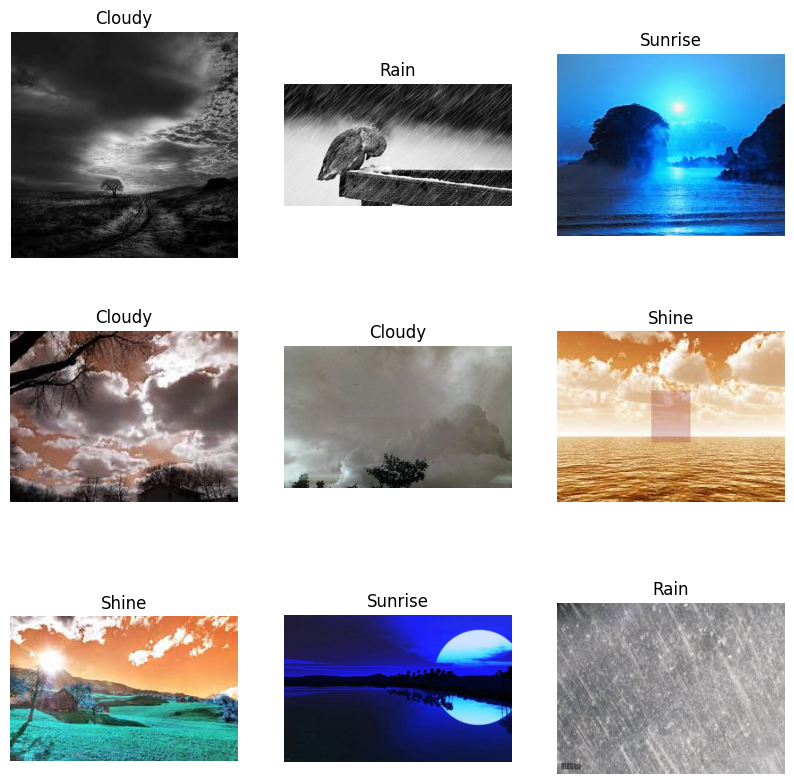

In [8]:
plt.figure(figsize=(10, 10))
class_name = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(data_pictures[i])
  plt.title(class_name[data_classes[i]])
  plt.axis('off')


## Resizing and Rescaling

In [9]:
def data_rescaling(IMG_SIZE):

  resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1./255)
  ])

  return resize_and_rescale

In [10]:
preprocessd_data = data_rescaling(200)
for i in range(len(data_pictures)):
  data_pictures[i] = preprocessd_data(data_pictures[i])

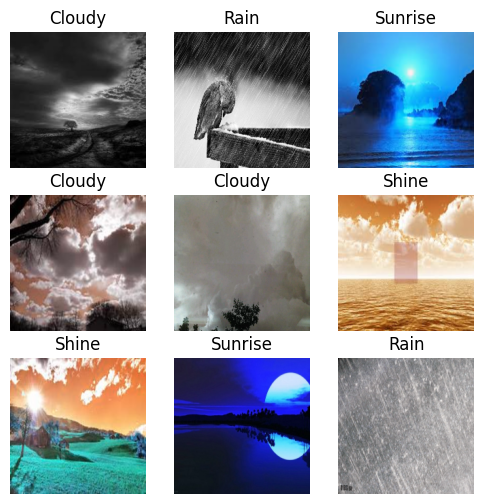

In [11]:
plt.figure(figsize=(6, 6))
class_name = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(data_pictures[i])
  plt.title(class_name[data_classes[i]])
  plt.axis('off')

## labeling the Data

In [12]:
data_labels = np.zeros((len(data_classes), 4))
for i in range(len(data_classes)):
  data_labels[i][data_classes[i]] = 1

[0. 1. 0. 0.]


TensorShape([200, 200, 3])

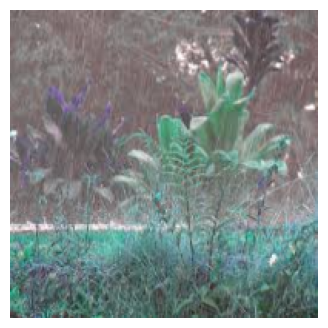

In [13]:
plt.figure(figsize=(4,4))
plt.imshow(data_pictures[120], cmap=plt.get_cmap('gray'))
plt.axis('off')
print(data_labels[120])
data_pictures[120].shape

In [14]:
data_labels[:][0]

array([1., 0., 0., 0.])

##Create DataFrame

In [15]:
data = {'pictures': data_pictures, 'Cloudy': data_labels[:,0], 'Rain': data_labels[:,1], 'Shine': data_labels[:,2], 'Sunrise': data_labels[:,3]}
df = pd.DataFrame(data)

In [16]:
df.shape

(1123, 5)

In [17]:
df.columns

Index(['pictures', 'Cloudy', 'Rain', 'Shine', 'Sunrise'], dtype='object')

##Data Spliting

In [18]:
X_train, X_val, y_train, y_val = train_test_split(data_pictures, data_labels, test_size=0.2, random_state=42)

In [19]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_train = X_train/255.0
X_val = X_val/255.0
print('x_train size: ', str(X_train.shape))
print('x_test size: ', str(X_val.shape))
print('y_train size: ', str(y_train.shape))
print('y_test size: ', str(y_val.shape))

x_train size:  (898, 200, 200, 3)
x_test size:  (225, 200, 200, 3)
y_train size:  (898, 4)
y_test size:  (225, 4)


##Report Functions

In [20]:
def diagrams(history, epochs = 50):
  #loss diagram
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  iterations = range(0, epochs)

  fig = plt.figure(figsize = (4, 3))
  plt.title("Train And Validation Data Loss")
  plt.plot(iterations, train_loss, 'r', label = 'Train Data Loss')
  plt.plot(iterations, val_loss, 'g', label = 'Validation Data Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  print()
  print()

  #accuracy diagram
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  iterations = range(0, epochs)

  fig = plt.figure(figsize = (4, 3))
  plt.title("Train And Validation Data Accuracy")
  plt.plot(iterations, train_acc, 'r', label = 'Train Data Accuracy')
  plt.plot(iterations, val_acc, 'g', label = 'Validation Data Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [21]:
def reports(model, X_train, y_train, X_val, y_val):
  #calssification report for train data classification
  print('calssification report for train data classification')
  y_pred_train = model.predict(X_train)
  y_pred_classification_train = np.argmax(y_pred_train, axis=1)
  y_true_train = np.argmax(y_train, axis=1)
  print(classification_report(y_true_train, y_pred_classification_train))
  print()

  #calssification report for test data classification
  print('calssification report for test data classification')
  y_pred_test = model.predict(X_val)
  y_pred_classification_test = np.argmax(y_pred_test, axis=1)
  y_true_test = np.argmax(y_val, axis=1)
  target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']
  print(classification_report(y_true_test, y_pred_classification_test))
  print()

  #train data confusion matrix
  print('train data confusion matrix')
  actual_train = np.argmax(y_train, axis=1)
  predicted_train = y_pred_classification_train
  confusion_matrix = metrics.confusion_matrix(actual_train, predicted_train)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3])
  cm_display.plot()
  plt.show()

  print()

  #test data confusion matrix
  print('test data confusion matrix')
  actual_test = np.argmax(y_val, axis=1)
  predicted_test = y_pred_classification_test
  confusion_matrix = metrics.confusion_matrix(actual_test, predicted_test)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3])
  cm_display.plot()
  plt.show()

# ***Implement Model***

## Fully Connected

### 3Hidden Layers

In [ ]:
def fully_connected_3HL(input_shape):
  input_img = tf.keras.layers.Input(shape= input_shape)
  F1 = tf.keras.layers.Flatten()(input_img)
  L1 = tf.keras.layers.Dense(50, activation='relu')(F1)
  L2 = tf.keras.layers.Dense(20, activation='relu')(L1)
  L3 = tf.keras.layers.Dense(35, activation='relu')(L2)
  output = tf.keras.layers.Dense(4, activation='softmax')(L3)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [ ]:
conv_model = fully_connected_3HL((300, 300, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 270000)            0         
                                                                 
 dense (Dense)               (None, 50)                13500050  
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 35)                735       
                                                                 
 dense_3 (Dense)             (None, 4)                 144       
                                                                 
Total params: 13501949 (51.51 MB)
Trainable params: 13501949 

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 4s 58ms/step - loss: 1.1062 - accuracy: 0.4866 - val_loss: 0.9613 - val_accuracy: 0.5733
Epoch 2/50
29/29 [==============================] - 2s 55ms/step - loss: 0.8314 - accuracy: 0.6470 - val_loss: 0.8629 - val_accuracy: 0.6711
Epoch 3/50
29/29 [==============================] - 2s 59ms/step - loss: 0.6789 - accuracy: 0.7561 - val_loss: 0.7749 - val_accuracy: 0.7289
Epoch 4/50
29/29 [==============================] - 1s 39ms/step - loss: 0.6286 - accuracy: 0.7595 - val_loss: 0.6785 - val_accuracy: 0.7556
Epoch 5/50
29/29 [==============================] - 1s 35ms/step - loss: 0.5771 - accuracy: 0.7762 - val_loss: 0.7039 - val_accuracy: 0.7244
Epoch 6/50
29/29 [==============================] - 1s 34ms/step - loss: 0.5288 - accuracy: 0.7918 - val_loss: 0.6144 - val_accuracy: 0.8000
Epoch 7/50
29/29 [==============================] - 1s 30ms/step - loss: 0.5717 - accuracy: 0.7728 - val_loss: 0.6160 - val_accuracy: 0.7733
Epoch 8/50
29

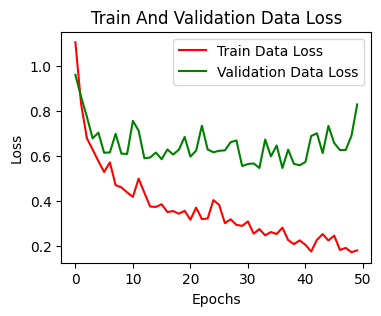

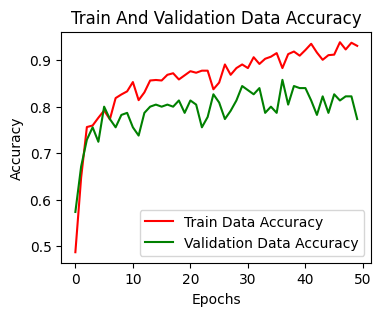

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       236
           1       0.69      0.97      0.81       173
           2       0.94      0.96      0.95       202
           3       1.00      0.99      0.99       287

    accuracy                           0.90       898
   macro avg       0.90      0.90      0.89       898
weighted avg       0.92      0.90      0.90       898


calssification report for test data classification
8/8 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.81      0.41      0.54        64
           1       0.54      0.95      0.69        41
           2       0.78      0.78      0.78        50
           3       0.99      1.00      0.99        70

    accuracy                           0.77       225
   macro avg       0.78      

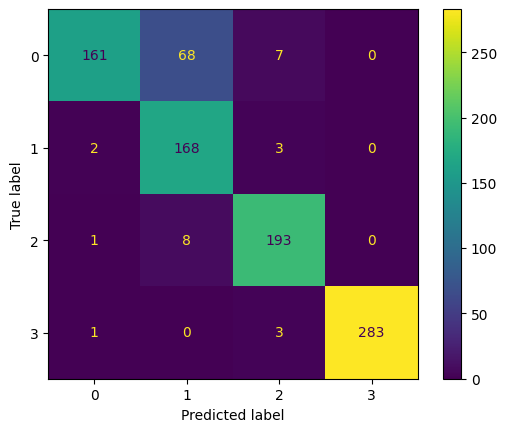


test data confusion matrix


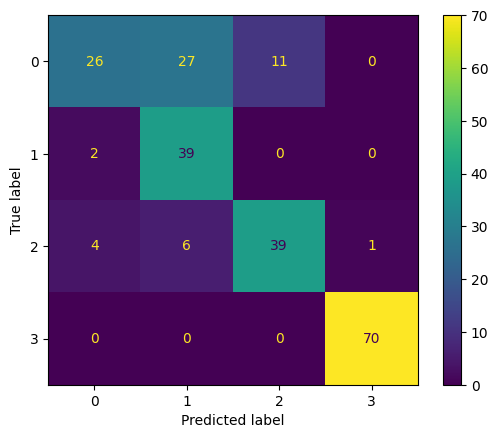

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

### 5Hidden Layers

In [ ]:
def fully_connected_5HL(input_shape):
  input_img = tf.keras.layers.Input(shape= input_shape)
  F1 = tf.keras.layers.Flatten()(input_img)
  L1 = tf.keras.layers.Dense(50, activation='relu')(F1)
  L2 = tf.keras.layers.Dense(20, activation='relu')(L1)
  L3 = tf.keras.layers.Dense(35, activation='relu')(L2)
  L4 = tf.keras.layers.Dense(25, activation='relu')(L3)
  L5 = tf.keras.layers.Dense(15, activation='relu')(L4)
  output = tf.keras.layers.Dense(4, activation='softmax')(L5)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [ ]:
conv_model = fully_connected_3HL((300, 300, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 flatten_2 (Flatten)         (None, 270000)            0         
                                                                 
 dense_10 (Dense)            (None, 50)                13500050  
                                                                 
 dense_11 (Dense)            (None, 20)                1020      
                                                                 
 dense_12 (Dense)            (None, 35)                735       
                                                                 
 dense_13 (Dense)            (None, 25)                900       
                                                                 
 dense_14 (Dense)            (None, 15)                390 

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 4s 59ms/step - loss: 1.2159 - accuracy: 0.4432 - val_loss: 1.0408 - val_accuracy: 0.4489
Epoch 2/50
29/29 [==============================] - 1s 33ms/step - loss: 0.9472 - accuracy: 0.6158 - val_loss: 0.8783 - val_accuracy: 0.7422
Epoch 3/50
29/29 [==============================] - 1s 36ms/step - loss: 0.7432 - accuracy: 0.7227 - val_loss: 0.7446 - val_accuracy: 0.7067
Epoch 4/50
29/29 [==============================] - 1s 40ms/step - loss: 0.6064 - accuracy: 0.7706 - val_loss: 0.6561 - val_accuracy: 0.7422
Epoch 5/50
29/29 [==============================] - 1s 37ms/step - loss: 0.5372 - accuracy: 0.8085 - val_loss: 0.6531 - val_accuracy: 0.7600
Epoch 6/50
29/29 [==============================] - 2s 56ms/step - loss: 0.5306 - accuracy: 0.8029 - val_loss: 0.6617 - val_accuracy: 0.7467
Epoch 7/50
29/29 [==============================] - 2s 53ms/step - loss: 0.4967 - accuracy: 0.8118 - val_loss: 0.5985 - val_accuracy: 0.7911
Epoch 8/50
29

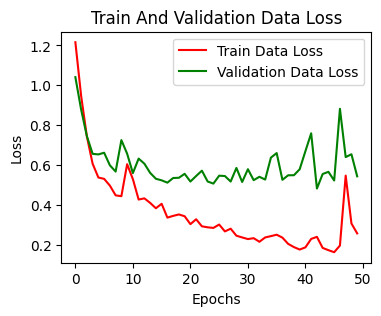

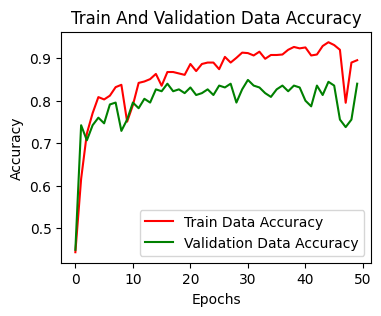

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       236
           1       0.89      0.86      0.87       173
           2       0.90      0.98      0.94       202
           3       0.98      0.99      0.98       287

    accuracy                           0.92       898
   macro avg       0.92      0.92      0.92       898
weighted avg       0.92      0.92      0.92       898


calssification report for test data classification
8/8 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        64
           1       0.74      0.85      0.80        41
           2       0.78      0.94      0.85        50
           3       0.92      1.00      0.96        70

    accuracy                           0.84       225
   macro avg       0.83      

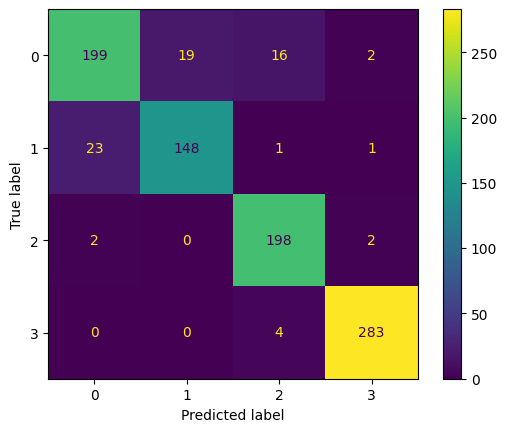


test data confusion matrix


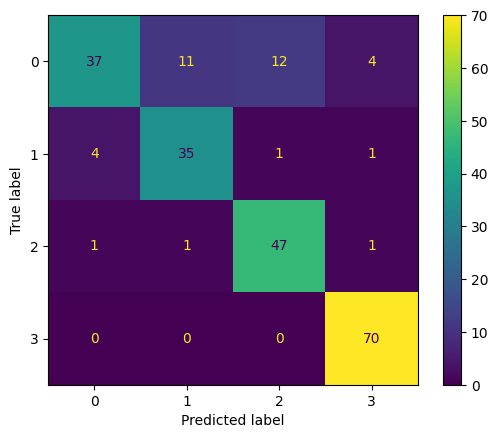

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

##Fully Connected with Dropout

### 3Hidden Layers

In [ ]:
def fully_connected_3HLDropout(input_shape):
  input_img = tf.keras.layers.Input(shape= input_shape)
  F1 = tf.keras.layers.Flatten()(input_img)
  D1 = tf.keras.layers.Dropout(0.2)(F1)
  L1 = tf.keras.layers.Dense(50, activation='relu')(D1)
  D2 = tf.keras.layers.Dropout(0.2)(L1)
  L2 = tf.keras.layers.Dense(20, activation='relu')(D2)
  D3 = tf.keras.layers.Dropout(0.2)(L2)
  L3 = tf.keras.layers.Dense(35, activation='relu')(D3)
  output = tf.keras.layers.Dense(4, activation='softmax')(L3)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [ ]:
conv_model = fully_connected_3HLDropout((300, 300, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 flatten_4 (Flatten)         (None, 270000)            0         
                                                                 
 dropout_3 (Dropout)         (None, 270000)            0         
                                                                 
 dense_20 (Dense)            (None, 50)                13500050  
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 20)                1020      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0   

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 5s 67ms/step - loss: 1.2208 - accuracy: 0.4354 - val_loss: 0.9271 - val_accuracy: 0.6089
Epoch 2/50
29/29 [==============================] - 1s 35ms/step - loss: 0.8825 - accuracy: 0.6269 - val_loss: 0.7517 - val_accuracy: 0.7511
Epoch 3/50
29/29 [==============================] - 1s 31ms/step - loss: 0.7817 - accuracy: 0.6860 - val_loss: 0.6532 - val_accuracy: 0.7556
Epoch 4/50
29/29 [==============================] - 1s 35ms/step - loss: 0.7524 - accuracy: 0.6849 - val_loss: 0.6417 - val_accuracy: 0.7778
Epoch 5/50
29/29 [==============================] - 1s 36ms/step - loss: 0.6719 - accuracy: 0.7249 - val_loss: 0.5972 - val_accuracy: 0.7733
Epoch 6/50
29/29 [==============================] - 1s 30ms/step - loss: 0.7003 - accuracy: 0.7305 - val_loss: 0.5941 - val_accuracy: 0.7911
Epoch 7/50
29/29 [==============================] - 1s 31ms/step - loss: 0.6240 - accuracy: 0.7606 - val_loss: 0.5761 - val_accuracy: 0.7822
Epoch 8/50
29

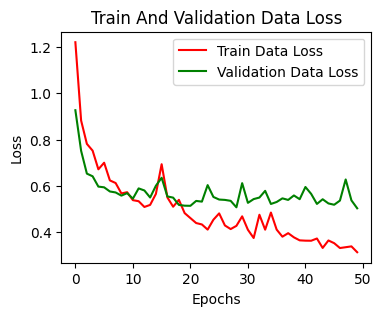

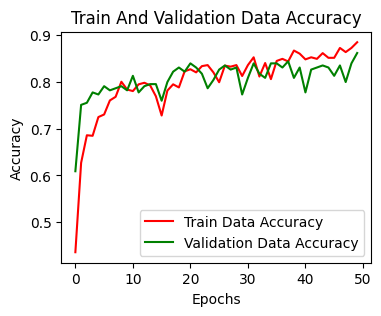

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       236
           1       0.90      0.84      0.87       173
           2       0.89      0.97      0.93       202
           3       1.00      0.97      0.99       287

    accuracy                           0.92       898
   macro avg       0.91      0.91      0.91       898
weighted avg       0.92      0.92      0.92       898


calssification report for test data classification
8/8 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        64
           1       0.82      0.80      0.81        41
           2       0.81      0.88      0.85        50
           3       0.97      0.96      0.96        70

    accuracy                           0.86       225
   macro avg       0.85      

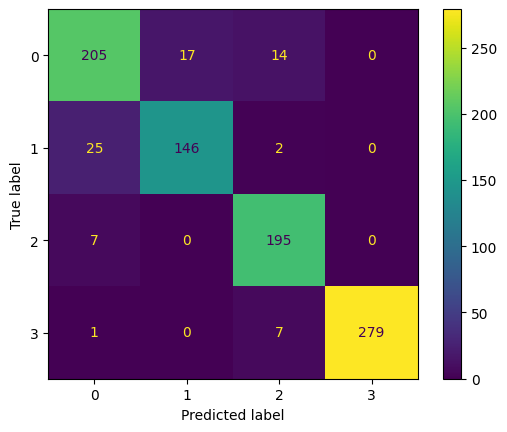


test data confusion matrix


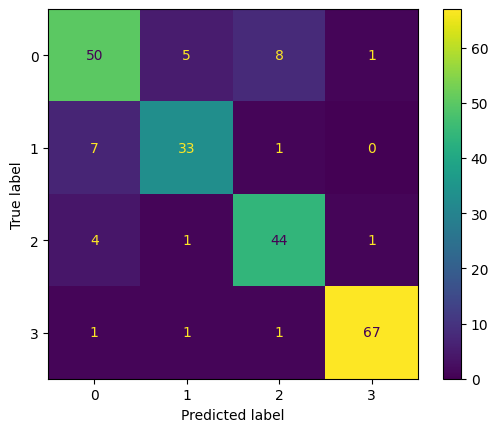

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

### 5Hidden Layers

In [ ]:
def fully_connected_5HLDropout(input_shape):
  input_img = tf.keras.layers.Input(shape= input_shape)
  F1 = tf.keras.layers.Flatten()(input_img)
  D1 = tf.keras.layers.Dropout(0.2)(F1)
  L1 = tf.keras.layers.Dense(50, activation='relu')(D1)
  D2 = tf.keras.layers.Dropout(0.2)(L1)
  L2 = tf.keras.layers.Dense(20, activation='relu')(D2)
  D3 = tf.keras.layers.Dropout(0.2)(L2)
  L3 = tf.keras.layers.Dense(35, activation='relu')(D3)
  D4 = tf.keras.layers.Dropout(0.2)(L3)
  L4 = tf.keras.layers.Dense(25, activation='relu')(D4)
  D5 = tf.keras.layers.Dropout(0.2)(L4)
  L5 = tf.keras.layers.Dense(15, activation='relu')(D5)
  D6 = tf.keras.layers.Dropout(0.2)(L5)
  output = tf.keras.layers.Dense(4, activation='softmax')(D6)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [ ]:
conv_model = fully_connected_5HLDropout((300, 300, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 flatten_5 (Flatten)         (None, 270000)            0         
                                                                 
 dropout_6 (Dropout)         (None, 270000)            0         
                                                                 
 dense_24 (Dense)            (None, 50)                13500050  
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_25 (Dense)            (None, 20)                1020      
                                                                 
 dropout_8 (Dropout)         (None, 20)                0   

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 5s 77ms/step - loss: 1.3385 - accuracy: 0.3285 - val_loss: 1.1756 - val_accuracy: 0.5156
Epoch 2/50
29/29 [==============================] - 1s 36ms/step - loss: 1.1410 - accuracy: 0.4499 - val_loss: 0.9501 - val_accuracy: 0.5111
Epoch 3/50
29/29 [==============================] - 1s 30ms/step - loss: 1.0066 - accuracy: 0.4733 - val_loss: 0.9177 - val_accuracy: 0.5289
Epoch 4/50
29/29 [==============================] - 1s 32ms/step - loss: 0.9367 - accuracy: 0.5323 - val_loss: 0.8975 - val_accuracy: 0.5111
Epoch 5/50
29/29 [==============================] - 1s 37ms/step - loss: 0.9120 - accuracy: 0.5390 - val_loss: 0.8802 - val_accuracy: 0.5200
Epoch 6/50
29/29 [==============================] - 1s 31ms/step - loss: 0.8798 - accuracy: 0.5356 - val_loss: 0.8865 - val_accuracy: 0.5867
Epoch 7/50
29/29 [==============================] - 1s 31ms/step - loss: 0.8847 - accuracy: 0.5612 - val_loss: 0.8660 - val_accuracy: 0.5422
Epoch 8/50
29

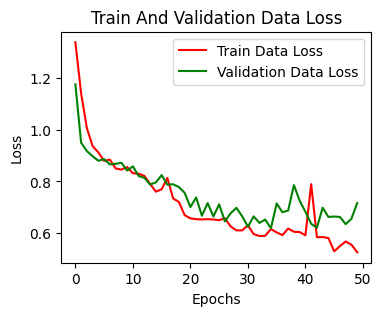

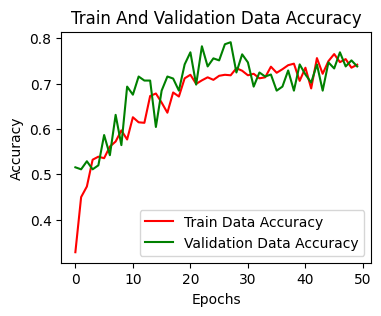

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.54      0.72      0.62       236
           1       0.63      0.62      0.62       173
           2       0.96      0.65      0.77       202
           3       1.00      0.95      0.97       287

    accuracy                           0.76       898
   macro avg       0.78      0.73      0.75       898
weighted avg       0.80      0.76      0.77       898


calssification report for test data classification
8/8 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.54      0.78      0.64        64
           1       0.64      0.56      0.60        41
           2       0.93      0.54      0.68        50
           3       0.99      0.94      0.96        70

    accuracy                           0.74       225
   macro avg       0.77      

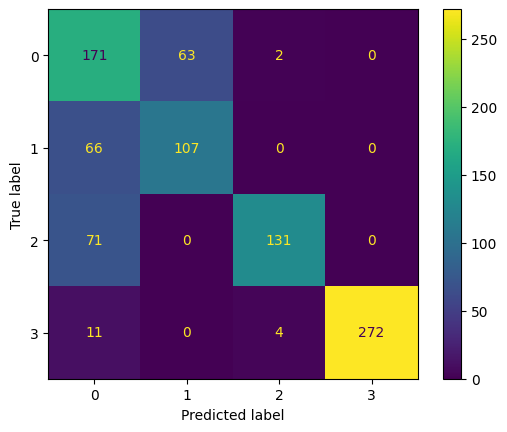


test data confusion matrix


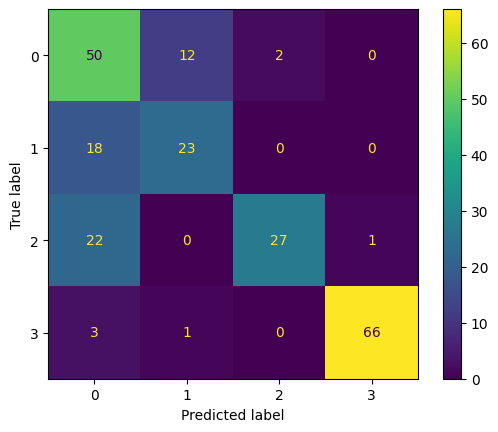

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

## Fully Connected with BathchNormalization

### 3Hidden Layers

In [ ]:
def fully_connected_3HLBathNorm(input_shape):
  input_img = tf.keras.layers.Input(shape= input_shape)
  F1 = tf.keras.layers.Flatten()(input_img)
  B1 = tf.keras.layers.BatchNormalization()(F1)
  L1 = tf.keras.layers.Dense(50, activation='relu')(B1)
  B2 = tf.keras.layers.BatchNormalization()(L1)
  L2 = tf.keras.layers.Dense(20, activation='relu')(B2)
  B3 = tf.keras.layers.BatchNormalization()(L2)
  L3 = tf.keras.layers.Dense(35, activation='relu')(B3)
  B4 = tf.keras.layers.BatchNormalization()(L3)
  output = tf.keras.layers.Dense(4, activation='softmax')(B4)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [ ]:
conv_model = fully_connected_3HLBathNorm((300, 300, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 flatten_6 (Flatten)         (None, 270000)            0         
                                                                 
 batch_normalization (Batch  (None, 270000)            1080000   
 Normalization)                                                  
                                                                 
 dense_30 (Dense)            (None, 50)                13500050  
                                                                 
 batch_normalization_1 (Bat  (None, 50)                200       
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 20)                1020

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 5s 61ms/step - loss: 1.0746 - accuracy: 0.5657 - val_loss: 1.2864 - val_accuracy: 0.3200
Epoch 2/50
29/29 [==============================] - 1s 36ms/step - loss: 0.7542 - accuracy: 0.7361 - val_loss: 1.3348 - val_accuracy: 0.3556
Epoch 3/50
29/29 [==============================] - 1s 36ms/step - loss: 0.6525 - accuracy: 0.7550 - val_loss: 1.3651 - val_accuracy: 0.2844
Epoch 4/50
29/29 [==============================] - 1s 40ms/step - loss: 0.5804 - accuracy: 0.7806 - val_loss: 1.3824 - val_accuracy: 0.2889
Epoch 5/50
29/29 [==============================] - 2s 60ms/step - loss: 0.5059 - accuracy: 0.8229 - val_loss: 1.4255 - val_accuracy: 0.2844
Epoch 6/50
29/29 [==============================] - 2s 56ms/step - loss: 0.4796 - accuracy: 0.8285 - val_loss: 1.4686 - val_accuracy: 0.3422
Epoch 7/50
29/29 [==============================] - 1s 41ms/step - loss: 0.4605 - accuracy: 0.8330 - val_loss: 1.4713 - val_accuracy: 0.3378
Epoch 8/50
29

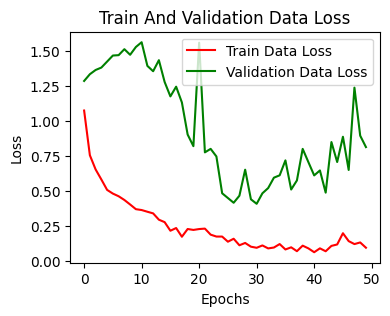

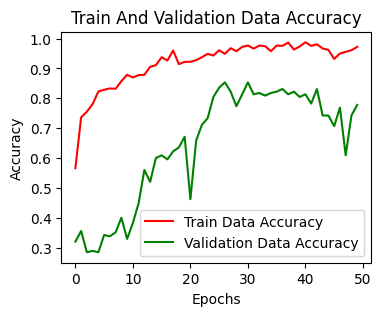

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       236
           1       0.82      0.99      0.90       173
           2       0.93      1.00      0.96       202
           3       1.00      0.86      0.93       287

    accuracy                           0.91       898
   macro avg       0.91      0.92      0.91       898
weighted avg       0.92      0.91      0.91       898


calssification report for test data classification
8/8 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.69      0.59      0.64        64
           1       0.66      0.95      0.78        41
           2       0.79      0.92      0.85        50
           3       0.98      0.74      0.85        70

    accuracy                           0.78       225
   macro avg       0.78      

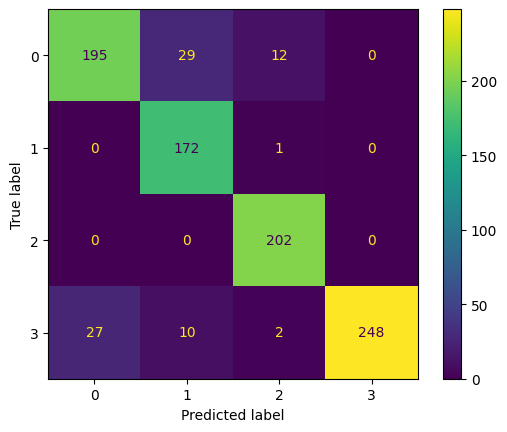


test data confusion matrix


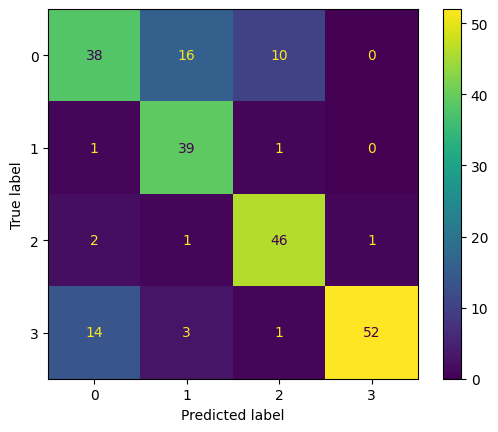

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

### 5Hidden Layers

In [ ]:
def fully_connected_5HLBatchNorm(input_shape):
  input_img = tf.keras.layers.Input(shape= input_shape)
  F1 = tf.keras.layers.Flatten()(input_img)
  B1 = tf.keras.layers.BatchNormalization()(F1)
  L1 = tf.keras.layers.Dense(50, activation='relu')(B1)
  B2 = tf.keras.layers.BatchNormalization()(L1)
  L2 = tf.keras.layers.Dense(20, activation='relu')(B2)
  B3 = tf.keras.layers.BatchNormalization()(L2)
  L3 = tf.keras.layers.Dense(35, activation='relu')(B3)
  B4 = tf.keras.layers.BatchNormalization()(L3)
  L4 = tf.keras.layers.Dense(25, activation='relu')(B4)
  B5 = tf.keras.layers.BatchNormalization()(L4)
  L5 = tf.keras.layers.Dense(15, activation='relu')(B5)
  B6 = tf.keras.layers.BatchNormalization()(L5)
  output = tf.keras.layers.Dense(4, activation='softmax')(B6)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [ ]:
conv_model = fully_connected_5HLBatchNorm((300, 300, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 flatten_7 (Flatten)         (None, 270000)            0         
                                                                 
 batch_normalization_4 (Bat  (None, 270000)            1080000   
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 50)                13500050  
                                                                 
 batch_normalization_5 (Bat  (None, 50)                200       
 chNormalization)                                                
                                                                 
 dense_35 (Dense)            (None, 20)                1020

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 6s 60ms/step - loss: 1.2133 - accuracy: 0.5345 - val_loss: 1.3646 - val_accuracy: 0.4800
Epoch 2/50
29/29 [==============================] - 1s 35ms/step - loss: 0.8691 - accuracy: 0.6503 - val_loss: 1.3630 - val_accuracy: 0.2889
Epoch 3/50
29/29 [==============================] - 1s 36ms/step - loss: 0.7549 - accuracy: 0.6927 - val_loss: 1.3739 - val_accuracy: 0.1867
Epoch 4/50
29/29 [==============================] - 1s 35ms/step - loss: 0.6853 - accuracy: 0.7327 - val_loss: 1.3866 - val_accuracy: 0.1867
Epoch 5/50
29/29 [==============================] - 1s 41ms/step - loss: 0.6280 - accuracy: 0.7383 - val_loss: 1.4526 - val_accuracy: 0.2844
Epoch 6/50
29/29 [==============================] - 2s 55ms/step - loss: 0.5649 - accuracy: 0.7829 - val_loss: 1.5999 - val_accuracy: 0.2844
Epoch 7/50
29/29 [==============================] - 1s 51ms/step - loss: 0.5027 - accuracy: 0.7996 - val_loss: 1.7379 - val_accuracy: 0.2844
Epoch 8/50
29

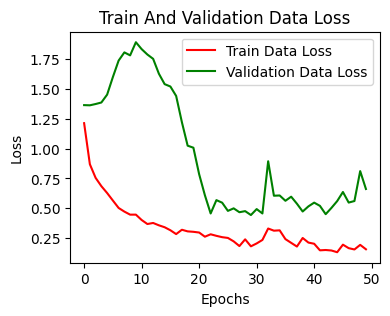

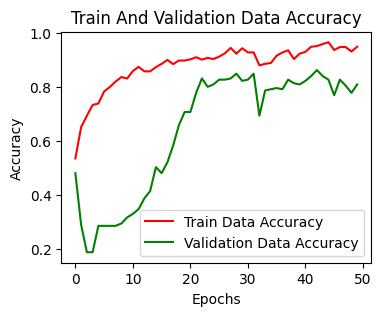

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       236
           1       0.98      0.86      0.92       173
           2       0.98      0.99      0.98       202
           3       0.99      1.00      0.99       287

    accuracy                           0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898


calssification report for test data classification
8/8 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       0.67      0.72      0.69        64
           1       0.85      0.54      0.66        41
           2       0.79      0.90      0.84        50
           3       0.95      0.99      0.97        70

    accuracy                           0.81       225
   macro avg       0.81      

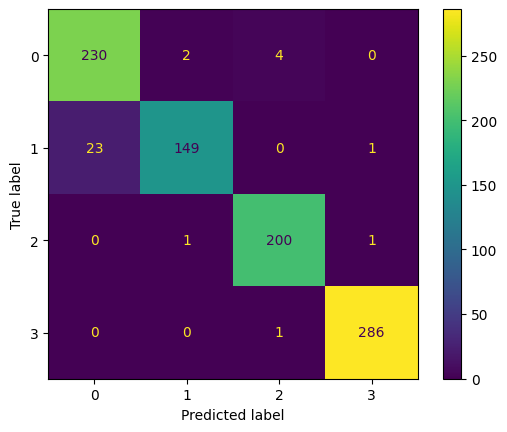


test data confusion matrix


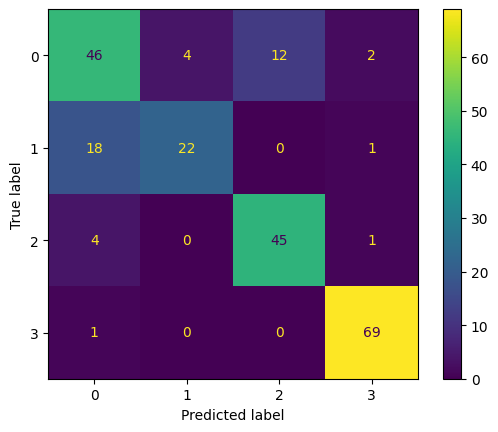

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

## CNN

### Conv Layers with Max Pooling

#### 3HiddenLayer Model

In [22]:
def convModel_3HL(input_shape):
  input_img = tf.keras.layers.Input(shape= input_shape)
  C1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same')(input_img)
  R1 = tf.keras.layers.ReLU()(C1)
  P1 = tf.keras.layers.MaxPool2D(pool_size=(6, 6), strides=(4, 4))(R1)
  C2 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same')(P1)
  R2 = tf.keras.layers.ReLU()(C2)
  P2 = tf.keras.layers.MaxPool2D(pool_size=(6, 6), strides=(4, 4))(R2)
  C3 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same')(P2)
  R3 = tf.keras.layers.ReLU()(C3)
  P3 = tf.keras.layers.MaxPool2D(pool_size=(6, 6), strides=(4, 4))(R3)
  F1 = tf.keras.layers.Flatten()(P3)
  output = tf.keras.layers.Dense(4, activation='softmax')(F1)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [ ]:
conv_model = convModel_3HL((300, 300, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 300, 300, 8)       392       
                                                                 
 re_lu (ReLU)                (None, 300, 300, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 8)         0         
 D)                                                              
                                                                 
 conv2d_23 (Conv2D)          (None, 74, 74, 8)         1032      
                                                                 
 re_lu_1 (ReLU)              (None, 74, 74, 8)         0         
                                                           

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 6s 83ms/step - loss: 1.3838 - accuracy: 0.3140 - val_loss: 1.3788 - val_accuracy: 0.3111
Epoch 2/50
29/29 [==============================] - 2s 58ms/step - loss: 1.3694 - accuracy: 0.3196 - val_loss: 1.3663 - val_accuracy: 0.3111
Epoch 3/50
29/29 [==============================] - 1s 41ms/step - loss: 1.3664 - accuracy: 0.3196 - val_loss: 1.3597 - val_accuracy: 0.3111
Epoch 4/50
29/29 [==============================] - 1s 36ms/step - loss: 1.3580 - accuracy: 0.3196 - val_loss: 1.3518 - val_accuracy: 0.3111
Epoch 5/50
29/29 [==============================] - 1s 41ms/step - loss: 1.3468 - accuracy: 0.3196 - val_loss: 1.3300 - val_accuracy: 0.3111
Epoch 6/50
29/29 [==============================] - 1s 38ms/step - loss: 1.2992 - accuracy: 0.3196 - val_loss: 1.2403 - val_accuracy: 0.4578
Epoch 7/50
29/29 [==============================] - 1s 41ms/step - loss: 1.1335 - accuracy: 0.4811 - val_loss: 0.9998 - val_accuracy: 0.5156
Epoch 8/50
29

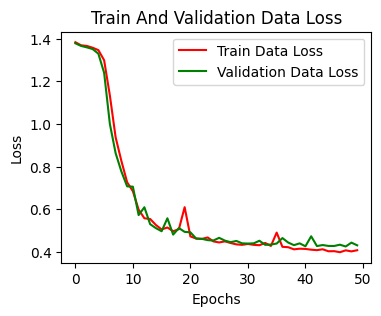

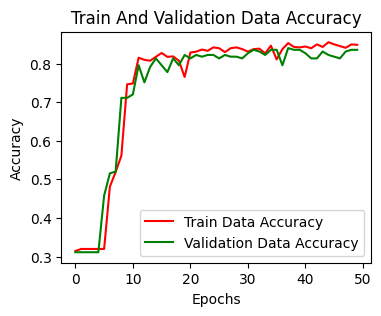

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       236
           1       0.82      0.65      0.73       173
           2       0.82      0.97      0.89       202
           3       0.98      0.97      0.98       287

    accuracy                           0.86       898
   macro avg       0.85      0.84      0.84       898
weighted avg       0.86      0.86      0.86       898


calssification report for test data classification
8/8 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        64
           1       0.74      0.68      0.71        41
           2       0.79      0.92      0.85        50
           3       0.99      0.99      0.99        70

    accuracy                           0.84       225
   macro avg       0.82      

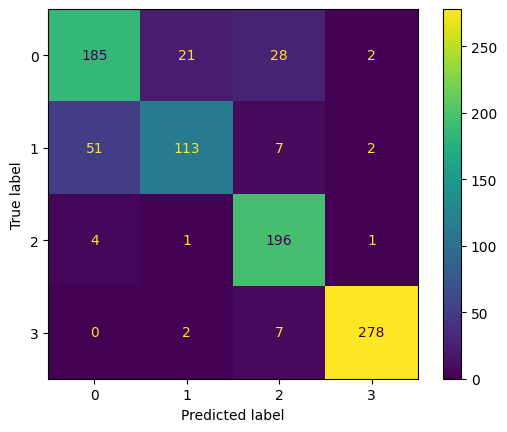


test data confusion matrix


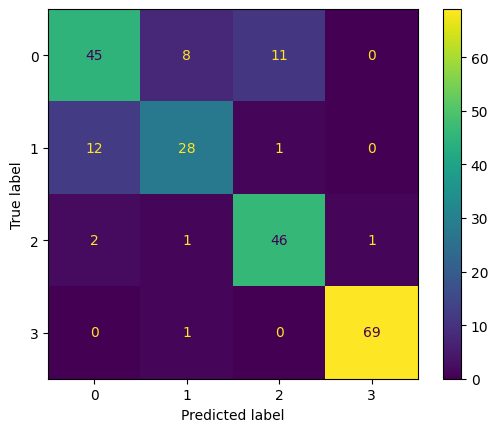

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

#### 5HiddenLayer Model

In [23]:
def convModel_5HL(input_shape):
  #read inputs
  input_img = tf.keras.layers.Input(shape= input_shape)

  # layer 1
  C1 = tf.keras.layers.Conv2D(filters=10, kernel_size=(4, 4), strides=(1, 1), padding='same')(input_img)
  R1 = tf.keras.layers.ReLU()(C1)
  P1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(R1)

  # layer 2
  C2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(2, 2), padding='same')(P1)
  R2 = tf.keras.layers.ReLU()(C2)
  P2 = tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=(2, 2))(R2)

  # layer 3
  C3 = tf.keras.layers.Conv2D(filters=10, kernel_size=(4, 4), strides=(1, 1), padding='same')(P2)
  R3 = tf.keras.layers.ReLU()(C3)
  P3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(R3)

  # layer 4
  C4 = tf.keras.layers.Conv2D(filters=8, kernel_size=(2, 2), strides=(1, 1), padding='same')(P3)
  R4 = tf.keras.layers.ReLU()(C4)
  P4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(R4)

  # Dense layers
  F1 = tf.keras.layers.Flatten()(P4)
  D1 = tf.keras.layers.Dense(100, activation='relu')(F1)
  D2 = tf.keras.layers.Dense(150, activation='relu')(D1)
  output = tf.keras.layers.Dense(4, activation='softmax')(D2)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [22]:
conv_model = convModel_5HL((200, 200, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 200, 200, 10)      490       
                                                                 
 re_lu_4 (ReLU)              (None, 200, 200, 10)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 100, 100, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 50, 50, 16)        656       
                                                                 
 re_lu_5 (ReLU)              (None, 50, 50, 16)        0         
                                                           

In [23]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 7s 48ms/step - loss: 1.3769 - accuracy: 0.3163 - val_loss: 1.3731 - val_accuracy: 0.2978
Epoch 2/50
29/29 [==============================] - 1s 20ms/step - loss: 1.3688 - accuracy: 0.3229 - val_loss: 1.3732 - val_accuracy: 0.2978
Epoch 3/50
29/29 [==============================] - 1s 21ms/step - loss: 1.3692 - accuracy: 0.3229 - val_loss: 1.3723 - val_accuracy: 0.2978
Epoch 4/50
29/29 [==============================] - 1s 20ms/step - loss: 1.3714 - accuracy: 0.3229 - val_loss: 1.3710 - val_accuracy: 0.2978
Epoch 5/50
29/29 [==============================] - 1s 22ms/step - loss: 1.3649 - accuracy: 0.3229 - val_loss: 1.3691 - val_accuracy: 0.2978
Epoch 6/50
29/29 [==============================] - 1s 29ms/step - loss: 1.3461 - accuracy: 0.3229 - val_loss: 1.3035 - val_accuracy: 0.2978
Epoch 7/50
29/29 [==============================] - 1s 33ms/step - loss: 1.1106 - accuracy: 0.3942 - val_loss: 1.0618 - val_accuracy: 0.5289
Epoch 8/50
29

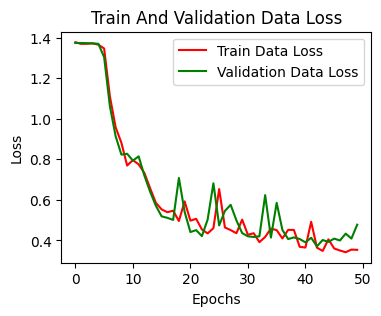

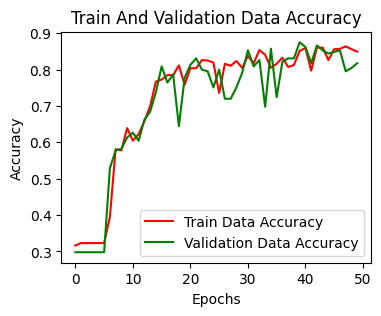

In [24]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       237
           1       0.94      0.40      0.56       172
           2       0.65      0.99      0.79       199
           3       1.00      0.93      0.96       290

    accuracy                           0.78       898
   macro avg       0.82      0.76      0.75       898
weighted avg       0.82      0.78      0.77       898


calssification report for test data classification
8/8 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.70      0.79      0.75        63
           1       0.90      0.43      0.58        42
           2       0.75      0.98      0.85        53
           3       0.98      0.96      0.97        67

    accuracy                           0.82       225
   macro avg       0.84      0

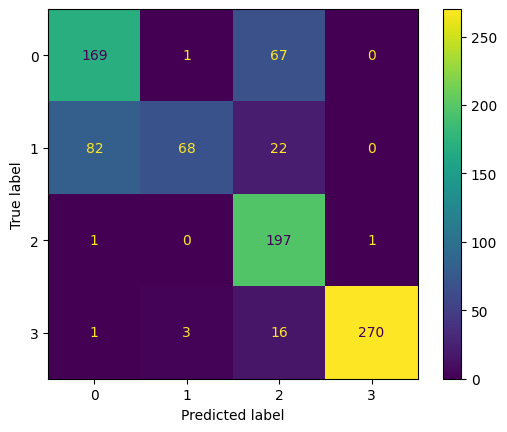


test data confusion matrix


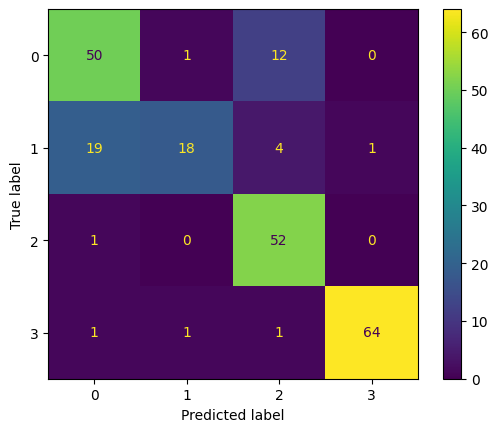

In [25]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

### Conv Layers with AVG Pooling

#### 3HiddenLayer Model

In [ ]:
def convModelAP_3HL(input_shape):
  input_img = tf.keras.layers.Input(shape= input_shape)
  C1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same')(input_img)
  R1 = tf.keras.layers.ReLU()(C1)
  P1 = tf.keras.layers.AveragePooling2D(pool_size=(6, 6), strides=(4, 4))(R1)
  C2 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same')(P1)
  R2 = tf.keras.layers.ReLU()(C2)
  P2 = tf.keras.layers.AveragePooling2D(pool_size=(6, 6), strides=(4, 4))(R2)
  C3 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same')(P2)
  R3 = tf.keras.layers.ReLU()(C3)
  P3 = tf.keras.layers.AveragePooling2D(pool_size=(6, 6), strides=(4, 4))(R3)
  F1 = tf.keras.layers.Flatten()(P3)
  output = tf.keras.layers.Dense(4, activation='softmax')(F1)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [ ]:
conv_model = convModelAP_3HL((300, 300, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 300, 300, 8)       392       
                                                                 
 re_lu (ReLU)                (None, 300, 300, 8)       0         
                                                                 
 average_pooling2d (Average  (None, 74, 74, 8)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_23 (Conv2D)          (None, 74, 74, 8)         1032      
                                                                 
 re_lu_1 (ReLU)              (None, 74, 74, 8)         0         
                                                             

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 6s 65ms/step - loss: 1.3823 - accuracy: 0.3096 - val_loss: 1.3773 - val_accuracy: 0.3022
Epoch 2/50
29/29 [==============================] - 1s 45ms/step - loss: 1.3702 - accuracy: 0.3218 - val_loss: 1.3743 - val_accuracy: 0.3022
Epoch 3/50
29/29 [==============================] - 2s 54ms/step - loss: 1.3685 - accuracy: 0.3218 - val_loss: 1.3721 - val_accuracy: 0.3022
Epoch 4/50
29/29 [==============================] - 2s 55ms/step - loss: 1.3644 - accuracy: 0.3218 - val_loss: 1.3683 - val_accuracy: 0.3022
Epoch 5/50
29/29 [==============================] - 1s 35ms/step - loss: 1.3564 - accuracy: 0.3218 - val_loss: 1.3519 - val_accuracy: 0.3022
Epoch 6/50
29/29 [==============================] - 1s 35ms/step - loss: 1.3110 - accuracy: 0.3352 - val_loss: 1.2663 - val_accuracy: 0.3111
Epoch 7/50
29/29 [==============================] - 1s 50ms/step - loss: 1.1614 - accuracy: 0.4866 - val_loss: 1.0736 - val_accuracy: 0.5467
Epoch 8/50
29

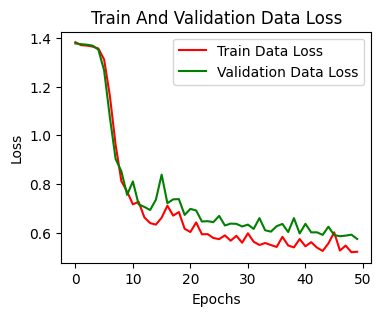

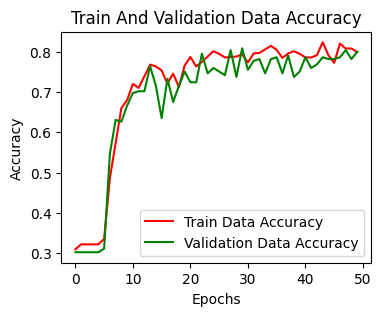

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       237
           1       0.69      0.66      0.67       167
           2       0.84      0.93      0.88       205
           3       0.95      0.95      0.95       289

    accuracy                           0.83       898
   macro avg       0.81      0.81      0.81       898
weighted avg       0.83      0.83      0.83       898


calssification report for test data classification
8/8 [==============================] - 1s 50ms/step
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        63
           1       0.79      0.72      0.76        47
           2       0.78      0.85      0.82        47
           3       0.93      0.93      0.93        68

    accuracy                           0.80       225
   macro avg       0.80      

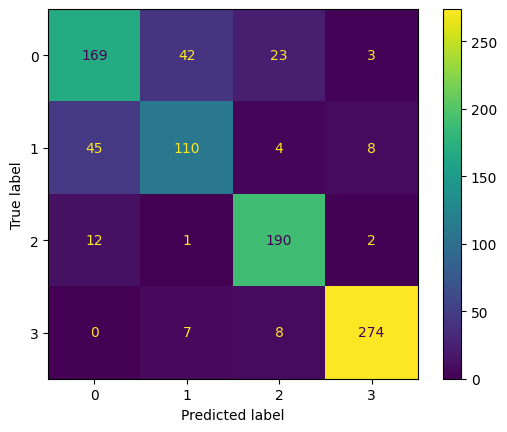


test data confusion matrix


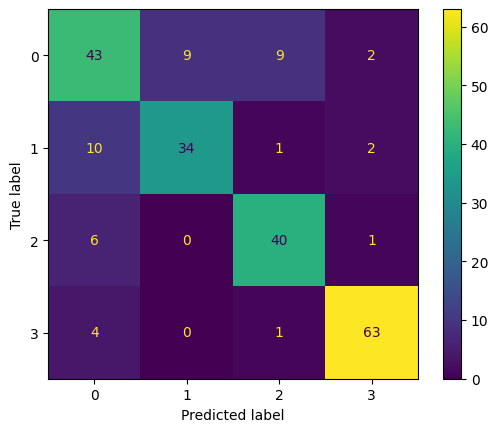

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

#### 5HiddenLayer Model

In [ ]:
def convModelAP_5HL(input_shape):
  input_img = tf.keras.layers.Input(shape= input_shape)
  C1 = tf.keras.layers.Conv2D(filters=10, kernel_size=(4, 4), strides=(1, 1), padding='same')(input_img)
  R1 = tf.keras.layers.ReLU()(C1)
  P1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(R1)

  C2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(2, 2), padding='same')(P1)
  R2 = tf.keras.layers.ReLU()(C2)
  P2 = tf.keras.layers.AveragePooling2D(pool_size=(4, 4), strides=(2, 2))(R2)

  C3 = tf.keras.layers.Conv2D(filters=10, kernel_size=(4, 4), strides=(1, 1), padding='same')(P2)
  R3 = tf.keras.layers.ReLU()(C3)
  P3 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(R3)

  C4 = tf.keras.layers.Conv2D(filters=8, kernel_size=(2, 2), strides=(1, 1), padding='same')(P3)
  R4 = tf.keras.layers.ReLU()(C4)
  P4 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(R4)

  F1 = tf.keras.layers.Flatten()(P4)
  D1 = tf.keras.layers.Dense(100, activation='relu')(F1)
  D2 = tf.keras.layers.Dense(150, activation='relu')(D1)
  output = tf.keras.layers.Dense(4, activation='softmax')(D2)

  model = tf.keras.Model(inputs= input_img, outputs= output)
  return model

In [ ]:
conv_model = convModelAP_5HL((300, 300, 3))
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 300, 300, 10)      490       
                                                                 
 re_lu_3 (ReLU)              (None, 300, 300, 10)      0         
                                                                 
 average_pooling2d_3 (Avera  (None, 150, 150, 10)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 16)        656       
                                                                 
 re_lu_4 (ReLU)              (None, 75, 75, 16)        0         
                                                           

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 5s 64ms/step - loss: 1.3768 - accuracy: 0.3140 - val_loss: 1.3745 - val_accuracy: 0.3022
Epoch 2/50
29/29 [==============================] - 1s 42ms/step - loss: 1.3688 - accuracy: 0.3218 - val_loss: 1.3801 - val_accuracy: 0.3022
Epoch 3/50
29/29 [==============================] - 1s 46ms/step - loss: 1.3684 - accuracy: 0.3218 - val_loss: 1.3757 - val_accuracy: 0.3022
Epoch 4/50
29/29 [==============================] - 2s 56ms/step - loss: 1.3692 - accuracy: 0.3218 - val_loss: 1.3749 - val_accuracy: 0.3022
Epoch 5/50
29/29 [==============================] - 1s 50ms/step - loss: 1.3687 - accuracy: 0.3218 - val_loss: 1.3746 - val_accuracy: 0.3022
Epoch 6/50
29/29 [==============================] - 1s 37ms/step - loss: 1.3674 - accuracy: 0.3218 - val_loss: 1.3742 - val_accuracy: 0.3022
Epoch 7/50
29/29 [==============================] - 1s 36ms/step - loss: 1.3682 - accuracy: 0.3218 - val_loss: 1.3736 - val_accuracy: 0.3022
Epoch 8/50
29

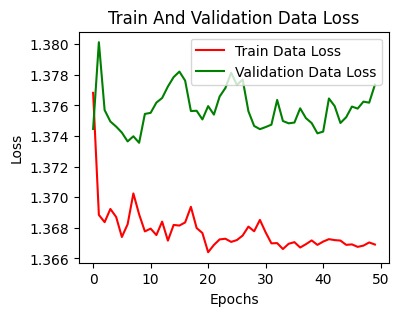

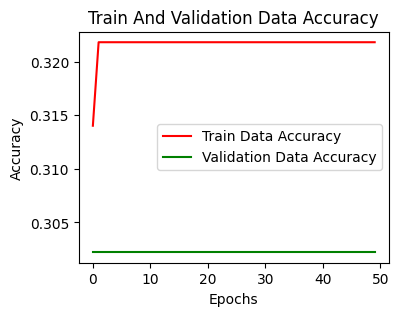

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

           0       0.14      0.04      0.07       237
           1       0.23      0.49      0.31       167
           2       0.18      0.40      0.25       205
           3       0.38      0.04      0.07       289

    accuracy                           0.20       898
   macro avg       0.23      0.24      0.18       898
weighted avg       0.24      0.20      0.16       898


calssification report for test data classification
8/8 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.41      0.11      0.18        63
           1       0.21      0.40      0.27        47
           2       0.17      0.38      0.24        47
           3       0.25      0.04      0.07        68

    accuracy                           0.21       225
   macro avg       0.26      

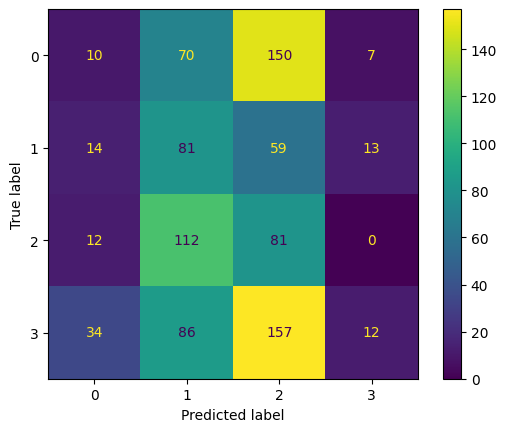


test data confusion matrix


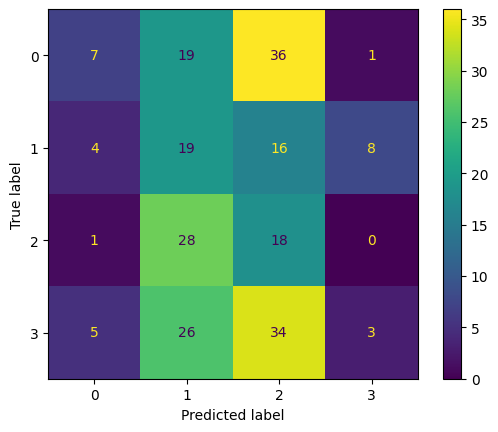

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

### Reidual Network

#### Identity Block

In [28]:
def identity_block(X, f, filters, initializer = random_uniform, training= True):

  X_shortcut = X
  F1, F2, F3 = filters
  #first component
  X = tf.keras.layers.Conv2D(F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
  X = tf.keras.layers.BatchNormalization(axis=3)(X, training=training)
  X = tf.keras.layers.Activation('relu')(X)
  #second component
  X = tf.keras.layers.Conv2D(F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
  X = tf.keras.layers.BatchNormalization(axis=3)(X, training = training)
  X = tf.keras.layers.Activation('relu')(X)
  #third component
  X = tf.keras.layers.Conv2D(F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
  X = tf.keras.layers.BatchNormalization(axis=3)(X, training = training)

  X = tf.keras.layers.Add()([X, X_shortcut])
  X = tf.keras.layers.Activation('relu')(X)

  return X

#### Convolutional Block

In [29]:
def convolutional_block(X, f, filters, s=2, initializer = random_uniform, training = True):

  X_shortcut = X
  F1, F2, F3 = filters

  #first component
  X = tf.keras.layers.Conv2D(F1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X)
  X = tf.keras.layers.BatchNormalization(axis=3)(X, training=training)
  X = tf.keras.layers.Activation('relu')(X)
  #second component
  X = tf.keras.layers.Conv2D(F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
  X = tf.keras.layers.BatchNormalization(axis=3)(X, training=training)
  X = tf.keras.layers.Activation('relu')(X)
  #third component
  X = tf.keras.layers.Conv2D(F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
  X = tf.keras.layers.BatchNormalization(axis=3)(X, training=training)

  X_shortcut = tf.keras.layers.Conv2D(F3, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
  X_shortcut = tf.keras.layers.BatchNormalization(axis=3)(X_shortcut, training=training)

  X = tf.keras.layers.Add()([X, X_shortcut])
  X =  X = tf.keras.layers.Activation('relu')(X)

  return X

#### ResNet implementation

In [30]:
from keras.src import initializers
def resnet_model(input_shape, classes):
  # read input
  X_input = tf.keras.layers.Input(input_shape)

  # zero padding
  X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)

  # layer 1
  X = tf.keras.layers.Conv2D(200, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
  X = tf.keras.layers.BatchNormalization(axis = 3)(X)
  X = tf.keras.layers.Activation('relu')(X)
  X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

  # layer 2
  X = convolutional_block(X, f = 3, filters = [64, 64, 64], s = 1)
  X = identity_block(X, 3, [64, 64, 64])
  X = identity_block(X, 3, [64, 64, 64])

  # layer 3
  X = convolutional_block(X, f = 3, filters = [128,128,128], s = 2)
  X = identity_block(X, 3,  [128,128,128])
  X = identity_block(X, 3,  [128,128,128])
  X = identity_block(X, 3,  [128,128,128])

  # layer 4
  X = convolutional_block(X, f = 3, filters = [256, 256, 256], s = 2)
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])

  # layer 5
  X = convolutional_block(X, f = 3, filters = [512, 512, 512], s = 2)
  X = identity_block(X, 3, [512, 512, 512])
  X = identity_block(X, 3, [512, 512, 512])

  # AveragePooling
  X = tf.keras.layers.AveragePooling2D((2, 2))(X)

  # Dense layers
  X = tf.keras.layers.Flatten()(X)
  X = tf.keras.layers.Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

  # model
  model = tf.keras.Model(inputs = X_input, outputs = X)

  return model


In [ ]:
conv_model = resnet_model((200, 200, 3), 4)
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 zero_padding2d_7 (ZeroPadd  (None, 206, 206, 3)          0         ['input_8[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_298 (Conv2D)         (None, 100, 100, 200)        29600     ['zero_padding2d_7[0][0]']    
                                                                                                  
 batch_normalization_276 (B  (None, 100, 100, 200)        800       ['conv2d_298[0][0]']    

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 44s 262ms/step - loss: 1.9630 - accuracy: 0.5345 - val_loss: 1.2893 - val_accuracy: 0.6133
Epoch 2/50
29/29 [==============================] - 6s 195ms/step - loss: 1.1854 - accuracy: 0.6715 - val_loss: 0.5865 - val_accuracy: 0.7822
Epoch 3/50
29/29 [==============================] - 6s 194ms/step - loss: 1.0377 - accuracy: 0.7038 - val_loss: 0.9007 - val_accuracy: 0.7289
Epoch 4/50
29/29 [==============================] - 6s 203ms/step - loss: 1.0684 - accuracy: 0.7428 - val_loss: 0.8034 - val_accuracy: 0.7911
Epoch 5/50
29/29 [==============================] - 6s 206ms/step - loss: 1.0498 - accuracy: 0.7160 - val_loss: 0.9000 - val_accuracy: 0.6000
Epoch 6/50
29/29 [==============================] - 6s 195ms/step - loss: 0.6083 - accuracy: 0.7639 - val_loss: 0.6663 - val_accuracy: 0.7111
Epoch 7/50
29/29 [==============================] - 6s 191ms/step - loss: 0.9580 - accuracy: 0.6559 - val_loss: 0.6884 - val_accuracy: 0.7333
Epoch

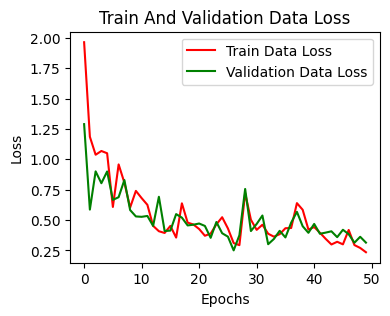

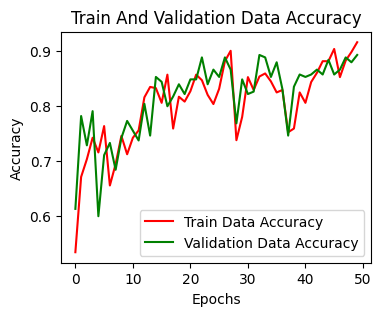

In [ ]:
diagrams(history)

### Inception Model

In [ ]:
def inception_block(X, filters_1x1, filters3x3_reduction, filters_3x3, filters5x5_reduction, filters_5x5, filters_pooling, kernel_init, bias_init):

  #layer 1 (1x1 convolution)
  conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(X)

  #layer 2 (3x3 convolution)
  conv_3x3 = tf.keras.layers.Conv2D(filters3x3_reduction, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(X)
  conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

  #layer 3 (5x5 convolution)
  conv_5x5 = tf.keras.layers.Conv2D(filters5x5_reduction, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(X)
  conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

  #layer 4 (Max Pooling)
  pool = tf.keras.layers.MaxPooling2D((3, 3), (1, 1), padding='same')(X)
  pool = tf.keras.layers.Conv2D(filters_pooling, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool)

  concat_model = tf.keras.layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool], axis=3)

  return concat_model


In [ ]:
kernel_init = tf.keras.initializers.glorot_uniform()
bias_init = tf.keras.initializers.Constant(value=0.2)

In [ ]:
def inception_model(input_shape, kernel_init, bias_init):

  input_img = tf.keras.layers.Input(shape= input_shape)
  x = tf.keras.layers.Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_img)
  x = tf.keras.layers.MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)
  x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
  x = tf.keras.layers.Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

  x = inception_block(x,
                      filters_1x1=64,
                      filters3x3_reduction=96,
                      filters_3x3=128,
                      filters5x5_reduction=16,
                      filters_5x5=32,
                      filters_pooling=32,
                      kernel_init= kernel_init,
                      bias_init= bias_init)



  x = tf.keras.layers.MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)



  x1 = tf.keras.layers.AveragePooling2D((5, 5), strides=3)(x)
  x1 = tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
  x1 = tf.keras.layers.Flatten()(x1)
  x1 = tf.keras.layers.Dense(1024, activation='relu')(x1)
  x1 = tf.keras.layers.Dropout(0.7)(x1)
  x1 = tf.keras.layers.Dense(4, activation='softmax')(x1)





  x = inception_block(x,
                      filters_1x1=112,
                      filters3x3_reduction=144,
                      filters_3x3=288,
                      filters5x5_reduction=32,
                      filters_5x5=64,
                      filters_pooling=64,
                      kernel_init= kernel_init,
                      bias_init= bias_init)


  x2 = tf.keras.layers.AveragePooling2D((5, 5), strides=3)(x)
  x2 = tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
  x2 = tf.keras.layers.Flatten()(x2)
  x2 = tf.keras.layers.Dense(1024, activation='relu')(x2)
  x2 = tf.keras.layers.Dropout(0.7)(x2)
  x2 = tf.keras.layers.Dense(4, activation='softmax')(x2)

  x = inception_block(x,
                      filters_1x1=256,
                      filters3x3_reduction=160,
                      filters_3x3=320,
                      filters5x5_reduction=32,
                      filters_5x5=128,
                      filters_pooling=128,
                      kernel_init= kernel_init,
                      bias_init= bias_init)

  x = tf.keras.layers.MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)


  x = inception_block(x,
                      filters_1x1=384,
                      filters3x3_reduction=192,
                      filters_3x3=384,
                      filters5x5_reduction=48,
                      filters_5x5=128,
                      filters_pooling=128,
                      kernel_init= kernel_init,
                      bias_init= bias_init)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  x = tf.keras.layers.Dropout(0.4)(x)

  x = tf.keras.layers.Dense(4, activation='softmax', name='output')(x)

  model = tf.keras.Model(input_img, [x, x1, x2])

  return model

In [ ]:
conv_model = inception_model((200, 200, 3), kernel_init, bias_init)
conv_model = resnet_model((200, 200, 3), 4)
conv_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)
conv_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 206, 206, 3)          0         ['input_9[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_187 (Conv2D)         (None, 100, 100, 200)        29600     ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_53 (Ba  (None, 100, 100, 200)        800       ['conv2d_187[0][0]']    

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = conv_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
29/29 [==============================] - 44s 253ms/step - loss: 1.8675 - accuracy: 0.5512 - val_loss: 14.1104 - val_accuracy: 0.2356
Epoch 2/50
29/29 [==============================] - 5s 187ms/step - loss: 1.0154 - accuracy: 0.6704 - val_loss: 9.2167 - val_accuracy: 0.2356
Epoch 3/50
29/29 [==============================] - 5s 180ms/step - loss: 1.0286 - accuracy: 0.7528 - val_loss: 2.3805 - val_accuracy: 0.3067
Epoch 4/50
29/29 [==============================] - 5s 182ms/step - loss: 1.5392 - accuracy: 0.7016 - val_loss: 3.6158 - val_accuracy: 0.4533
Epoch 5/50
29/29 [==============================] - 5s 188ms/step - loss: 1.7378 - accuracy: 0.6837 - val_loss: 1.5730 - val_accuracy: 0.5378
Epoch 6/50
29/29 [==============================] - 6s 192ms/step - loss: 1.0607 - accuracy: 0.6615 - val_loss: 1.1937 - val_accuracy: 0.6800
Epoch 7/50
29/29 [==============================] - 5s 181ms/step - loss: 0.6322 - accuracy: 0.7862 - val_loss: 1.5459 - val_accuracy: 0.6178
Epoc

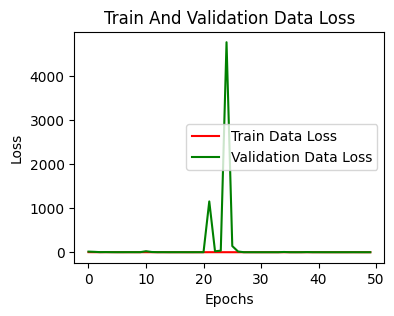

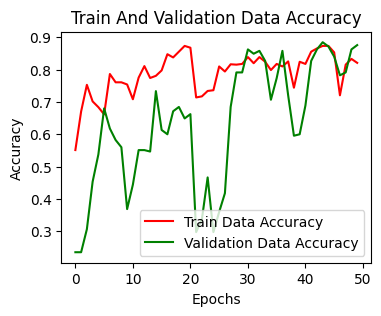

In [ ]:
diagrams(history)

calssification report for train data classification
29/29 [==============================] - 3s 55ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       237
           1       0.85      0.77      0.80       172
           2       0.84      0.90      0.87       199
           3       0.99      0.96      0.97       290

    accuracy                           0.87       898
   macro avg       0.86      0.86      0.86       898
weighted avg       0.87      0.87      0.87       898


calssification report for test data classification
8/8 [==============================] - 0s 50ms/step
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        63
           1       0.80      0.79      0.80        42
           2       0.87      0.87      0.87        53
           3       0.98      0.97      0.98        67

    accuracy                           0.88       225
   macro avg       0.87      

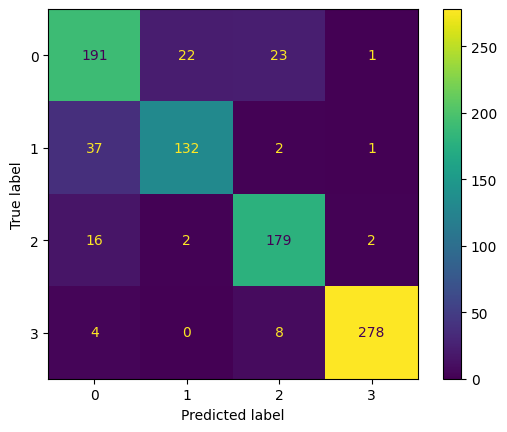


test data confusion matrix


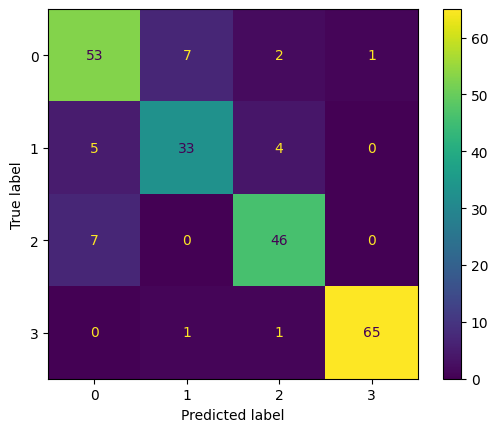

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  reports(conv_model, X_train, y_train, X_val, y_val)

# ***K-Fold Cross Validation***

## Model 1

Epoch 1/50
29/29 [==============================] - 7s 27ms/step - loss: 1.3023 - accuracy: 0.3842
Epoch 2/50
29/29 [==============================] - 1s 21ms/step - loss: 0.7341 - accuracy: 0.7105
Epoch 3/50
29/29 [==============================] - 1s 22ms/step - loss: 0.5928 - accuracy: 0.7873
Epoch 4/50
29/29 [==============================] - 1s 21ms/step - loss: 0.4953 - accuracy: 0.7918
Epoch 5/50
29/29 [==============================] - 1s 20ms/step - loss: 0.4631 - accuracy: 0.8207
Epoch 6/50
29/29 [==============================] - 1s 31ms/step - loss: 0.3836 - accuracy: 0.8497
Epoch 7/50
29/29 [==============================] - 1s 29ms/step - loss: 0.3741 - accuracy: 0.8586
Epoch 8/50
29/29 [==============================] - 1s 23ms/step - loss: 0.3189 - accuracy: 0.8731
Epoch 9/50
29/29 [==============================] - 1s 25ms/step - loss: 0.4202 - accuracy: 0.8552
Epoch 10/50
29/29 [==============================] - 1s 26ms/step - loss: 0.3223 - accuracy: 0.8909
Epoch 11/

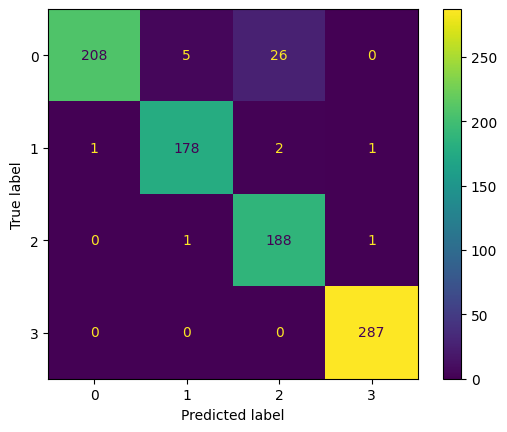


test data confusion matrix


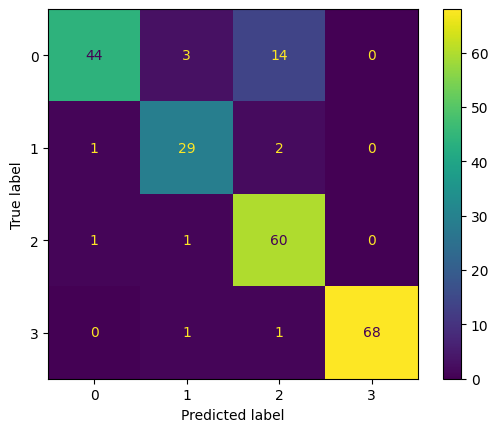

Epoch 1/50
29/29 [==============================] - 5s 27ms/step - loss: 1.0722 - accuracy: 0.5412
Epoch 2/50
29/29 [==============================] - 1s 24ms/step - loss: 0.6712 - accuracy: 0.7194
Epoch 3/50
29/29 [==============================] - 1s 20ms/step - loss: 0.6173 - accuracy: 0.7316
Epoch 4/50
29/29 [==============================] - 1s 21ms/step - loss: 0.5260 - accuracy: 0.8018
Epoch 5/50
29/29 [==============================] - 1s 21ms/step - loss: 0.4433 - accuracy: 0.8296
Epoch 6/50
29/29 [==============================] - 1s 19ms/step - loss: 0.4385 - accuracy: 0.8296
Epoch 7/50
29/29 [==============================] - 1s 18ms/step - loss: 0.4224 - accuracy: 0.8263
Epoch 8/50
29/29 [==============================] - 1s 18ms/step - loss: 0.3653 - accuracy: 0.8519
Epoch 9/50
29/29 [==============================] - 1s 18ms/step - loss: 0.3302 - accuracy: 0.8764
Epoch 10/50
29/29 [==============================] - 1s 18ms/step - loss: 0.3220 - accuracy: 0.8842
Epoch 11/

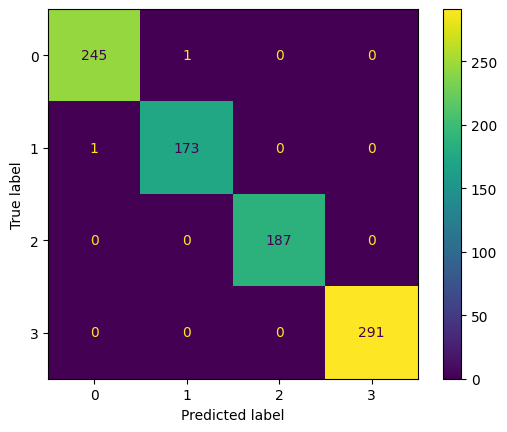


test data confusion matrix


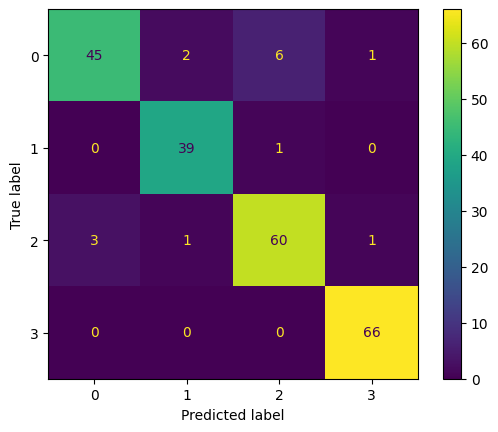

Epoch 1/50
29/29 [==============================] - 3s 21ms/step - loss: 1.0920 - accuracy: 0.4978
Epoch 2/50
29/29 [==============================] - 1s 19ms/step - loss: 0.7043 - accuracy: 0.6815
Epoch 3/50
29/29 [==============================] - 1s 18ms/step - loss: 0.6803 - accuracy: 0.6826
Epoch 4/50
29/29 [==============================] - 1s 18ms/step - loss: 0.5796 - accuracy: 0.7528
Epoch 5/50
29/29 [==============================] - 1s 17ms/step - loss: 0.5015 - accuracy: 0.7973
Epoch 6/50
29/29 [==============================] - 1s 18ms/step - loss: 0.5878 - accuracy: 0.7728
Epoch 7/50
29/29 [==============================] - 1s 19ms/step - loss: 0.4954 - accuracy: 0.8051
Epoch 8/50
29/29 [==============================] - 1s 20ms/step - loss: 0.3969 - accuracy: 0.8641
Epoch 9/50
29/29 [==============================] - 1s 19ms/step - loss: 0.3849 - accuracy: 0.8563
Epoch 10/50
29/29 [==============================] - 1s 23ms/step - loss: 0.3343 - accuracy: 0.8686
Epoch 11/

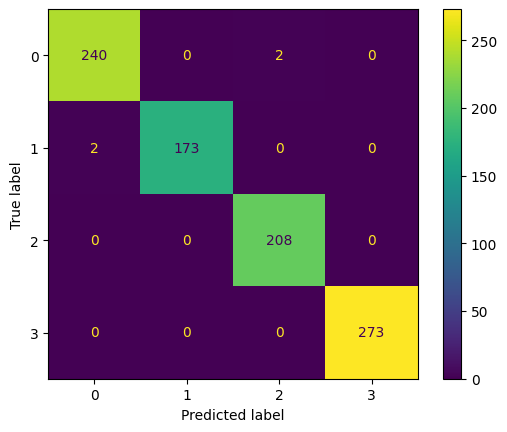


test data confusion matrix


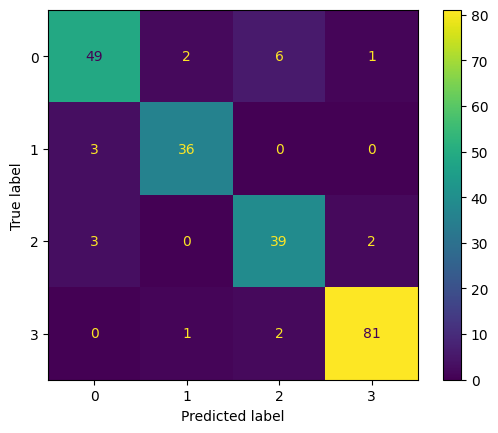

Epoch 1/50
29/29 [==============================] - 4s 29ms/step - loss: 1.0751 - accuracy: 0.5306
Epoch 2/50
29/29 [==============================] - 1s 19ms/step - loss: 0.7012 - accuracy: 0.6986
Epoch 3/50
29/29 [==============================] - 1s 18ms/step - loss: 0.6592 - accuracy: 0.7353
Epoch 4/50
29/29 [==============================] - 1s 18ms/step - loss: 0.5077 - accuracy: 0.8254
Epoch 5/50
29/29 [==============================] - 1s 18ms/step - loss: 0.4917 - accuracy: 0.8009
Epoch 6/50
29/29 [==============================] - 1s 18ms/step - loss: 0.4603 - accuracy: 0.8309
Epoch 7/50
29/29 [==============================] - 1s 19ms/step - loss: 0.3711 - accuracy: 0.8665
Epoch 8/50
29/29 [==============================] - 1s 18ms/step - loss: 0.4252 - accuracy: 0.8454
Epoch 9/50
29/29 [==============================] - 1s 17ms/step - loss: 0.3318 - accuracy: 0.8821
Epoch 10/50
29/29 [==============================] - 1s 18ms/step - loss: 0.3124 - accuracy: 0.8877
Epoch 11/

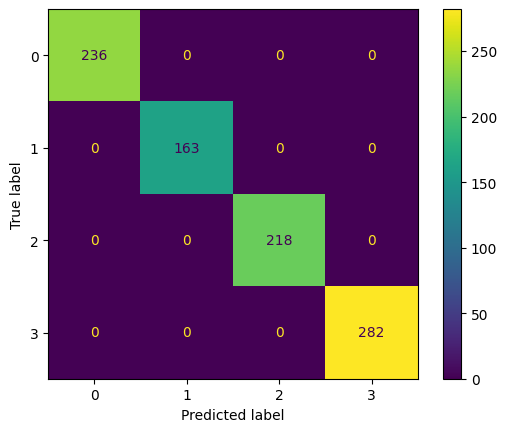


test data confusion matrix


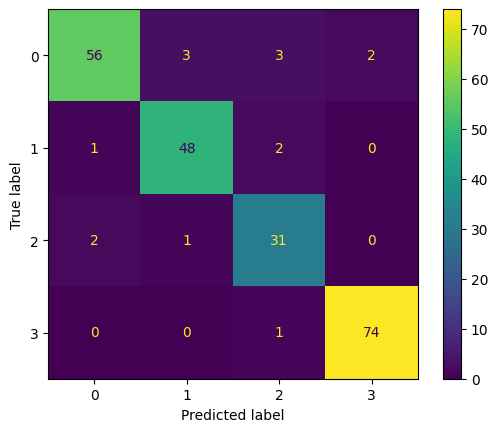

Epoch 1/50
29/29 [==============================] - 3s 20ms/step - loss: 1.2771 - accuracy: 0.3504
Epoch 2/50
29/29 [==============================] - 1s 20ms/step - loss: 0.7380 - accuracy: 0.6885
Epoch 3/50
29/29 [==============================] - 1s 19ms/step - loss: 0.5562 - accuracy: 0.7909
Epoch 4/50
29/29 [==============================] - 1s 19ms/step - loss: 0.4553 - accuracy: 0.8231
Epoch 5/50
29/29 [==============================] - 1s 18ms/step - loss: 0.4122 - accuracy: 0.8354
Epoch 6/50
29/29 [==============================] - 0s 17ms/step - loss: 0.3706 - accuracy: 0.8521
Epoch 7/50
29/29 [==============================] - 1s 17ms/step - loss: 0.3414 - accuracy: 0.8587
Epoch 8/50
29/29 [==============================] - 1s 20ms/step - loss: 0.3223 - accuracy: 0.8743
Epoch 9/50
29/29 [==============================] - 1s 21ms/step - loss: 0.2683 - accuracy: 0.9043
Epoch 10/50
29/29 [==============================] - 1s 21ms/step - loss: 0.2868 - accuracy: 0.8977
Epoch 11/

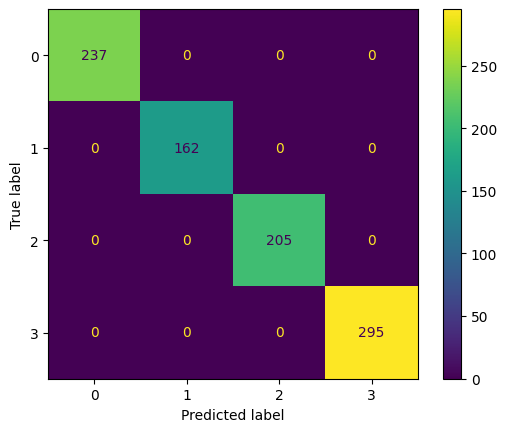


test data confusion matrix


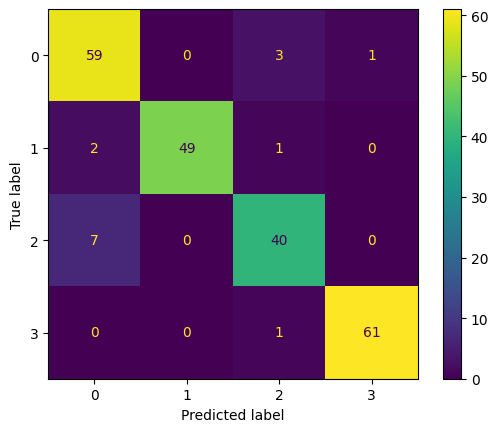


Total Accuracy:  0.9207698464393616
Total Loss:  0.4223648548126221


In [24]:
from keras.src.utils.conv_utils import conv_output_shape
inputs = np.array(data_pictures)
outputs = np.array(data_labels)

fold_num = 1
folds_accuracy = []
folds_loss = []

# K0Fold implementation
kfold = KFold(n_splits=5, shuffle=True)
for train, test in kfold.split(inputs, outputs):
  model = convModel_5HL((200, 200, 3))      #model
  model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
  )
  # train the model
  tf.debugging.set_log_device_placement(True)
  with tf.device('/GPU:0'): #using gpu
    history = model.fit(inputs[train], outputs[train], epochs=50)
  print()

  # evaluate the model
  scores = model.evaluate(inputs[test], outputs[test])
  print(f'Scores for Fold {fold_num} : {model.metrics_names[0]} = {scores[0]} and {model.metrics_names[1]} = {scores[1]}')
  print()

  folds_loss.append(scores[0])
  folds_accuracy.append(scores[1])
  fold_num = fold_num + 1
  # evaluate the model
  tf.debugging.set_log_device_placement(True)
  with tf.device('/GPU:0'): #using gpu
    reports(model, inputs[train], outputs[train], inputs[test], outputs[test])

print()
print('Total Accuracy: ', str(np.mean(folds_accuracy)))
print('Total Loss: ', str(np.mean(folds_loss)))

## Model 2

Epoch 1/50
29/29 [==============================] - 41s 171ms/step - loss: 1.9983 - accuracy: 0.5958
Epoch 2/50
29/29 [==============================] - 5s 173ms/step - loss: 0.7087 - accuracy: 0.7728
Epoch 3/50
29/29 [==============================] - 5s 171ms/step - loss: 0.7870 - accuracy: 0.7840
Epoch 4/50
29/29 [==============================] - 5s 184ms/step - loss: 1.1420 - accuracy: 0.6927
Epoch 5/50
29/29 [==============================] - 5s 174ms/step - loss: 0.7128 - accuracy: 0.7205
Epoch 6/50
29/29 [==============================] - 5s 173ms/step - loss: 0.6536 - accuracy: 0.7517
Epoch 7/50
29/29 [==============================] - 5s 175ms/step - loss: 0.6389 - accuracy: 0.7929
Epoch 8/50
29/29 [==============================] - 5s 173ms/step - loss: 0.9384 - accuracy: 0.7728
Epoch 9/50
29/29 [==============================] - 5s 175ms/step - loss: 0.6091 - accuracy: 0.7450
Epoch 10/50
29/29 [==============================] - 5s 174ms/step - loss: 0.5128 - accuracy: 0.799

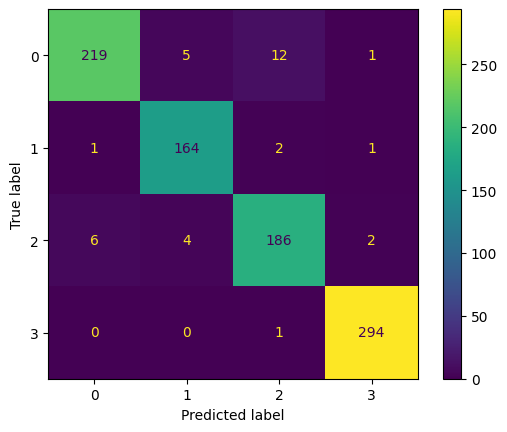


test data confusion matrix


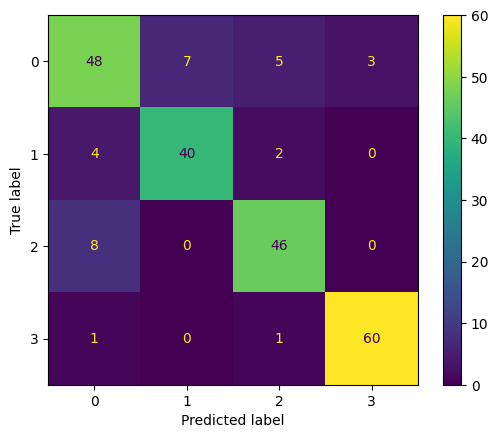

Epoch 1/50
29/29 [==============================] - 41s 171ms/step - loss: 2.0392 - accuracy: 0.5780
Epoch 2/50
29/29 [==============================] - 5s 174ms/step - loss: 1.1907 - accuracy: 0.7461
Epoch 3/50
29/29 [==============================] - 5s 171ms/step - loss: 0.7049 - accuracy: 0.7595
Epoch 4/50
29/29 [==============================] - 5s 171ms/step - loss: 0.7987 - accuracy: 0.7539
Epoch 5/50
29/29 [==============================] - 5s 175ms/step - loss: 0.7850 - accuracy: 0.7171
Epoch 6/50
29/29 [==============================] - 5s 173ms/step - loss: 0.8803 - accuracy: 0.7294
Epoch 7/50
29/29 [==============================] - 5s 175ms/step - loss: 0.7836 - accuracy: 0.7171
Epoch 8/50
29/29 [==============================] - 5s 175ms/step - loss: 0.7363 - accuracy: 0.7661
Epoch 9/50
29/29 [==============================] - 5s 172ms/step - loss: 0.5017 - accuracy: 0.8163
Epoch 10/50
29/29 [==============================] - 5s 174ms/step - loss: 0.5265 - accuracy: 0.806

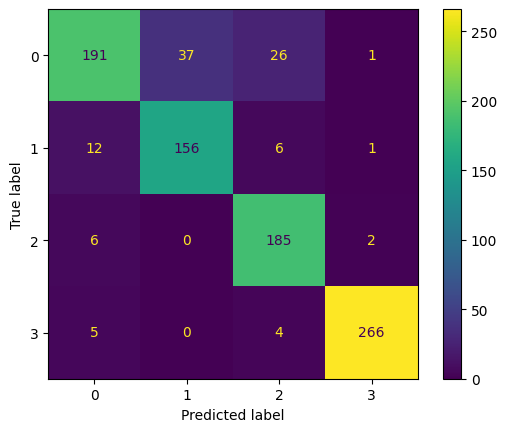


test data confusion matrix


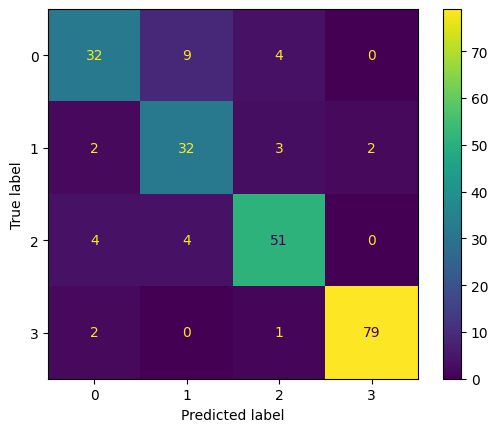

Epoch 1/50
29/29 [==============================] - 42s 172ms/step - loss: 1.4399 - accuracy: 0.6114
Epoch 2/50
29/29 [==============================] - 5s 172ms/step - loss: 1.0365 - accuracy: 0.6993
Epoch 3/50
29/29 [==============================] - 5s 171ms/step - loss: 0.5869 - accuracy: 0.8040
Epoch 4/50
29/29 [==============================] - 5s 175ms/step - loss: 0.4455 - accuracy: 0.8419
Epoch 5/50
29/29 [==============================] - 5s 173ms/step - loss: 0.4691 - accuracy: 0.8385
Epoch 6/50
29/29 [==============================] - 5s 174ms/step - loss: 0.9530 - accuracy: 0.7227
Epoch 7/50
29/29 [==============================] - 5s 175ms/step - loss: 0.6729 - accuracy: 0.7517
Epoch 8/50
29/29 [==============================] - 5s 172ms/step - loss: 0.5684 - accuracy: 0.8229
Epoch 9/50
29/29 [==============================] - 5s 172ms/step - loss: 0.8171 - accuracy: 0.7339
Epoch 10/50
29/29 [==============================] - 5s 173ms/step - loss: 0.6655 - accuracy: 0.751

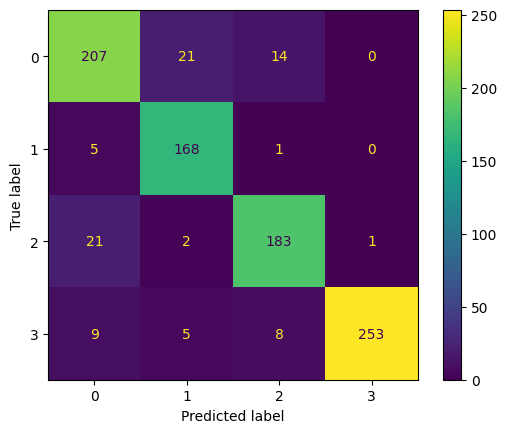


test data confusion matrix


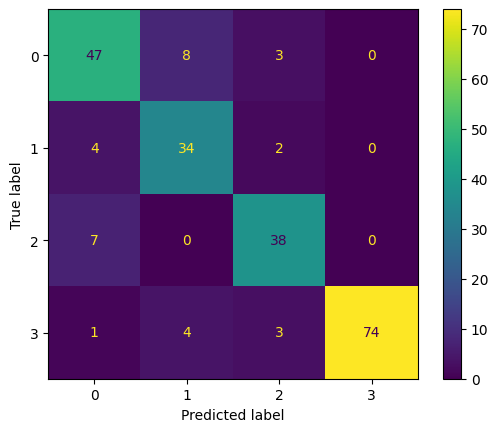

Epoch 1/50
29/29 [==============================] - 44s 207ms/step - loss: 2.0431 - accuracy: 0.6218
Epoch 2/50
29/29 [==============================] - 5s 173ms/step - loss: 1.0022 - accuracy: 0.7041
Epoch 3/50
29/29 [==============================] - 5s 174ms/step - loss: 0.9476 - accuracy: 0.7408
Epoch 4/50
29/29 [==============================] - 5s 174ms/step - loss: 0.6648 - accuracy: 0.7564
Epoch 5/50
29/29 [==============================] - 5s 174ms/step - loss: 0.5199 - accuracy: 0.8220
Epoch 6/50
29/29 [==============================] - 5s 178ms/step - loss: 0.4861 - accuracy: 0.8142
Epoch 7/50
29/29 [==============================] - 5s 174ms/step - loss: 0.7299 - accuracy: 0.7998
Epoch 8/50
29/29 [==============================] - 5s 175ms/step - loss: 0.5886 - accuracy: 0.7931
Epoch 9/50
29/29 [==============================] - 5s 175ms/step - loss: 0.5492 - accuracy: 0.8265
Epoch 10/50
29/29 [==============================] - 5s 171ms/step - loss: 0.4637 - accuracy: 0.848

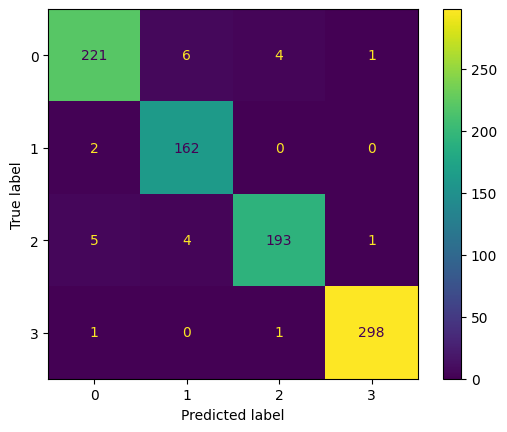


test data confusion matrix


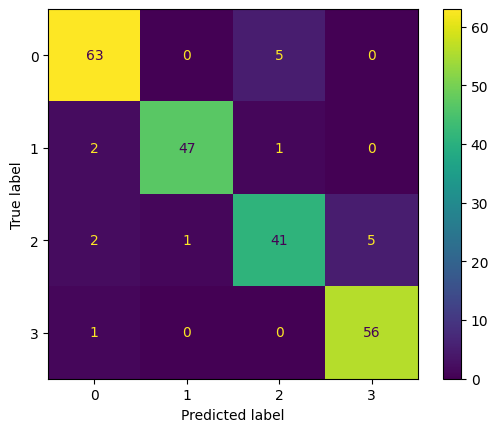

Epoch 1/50
29/29 [==============================] - 41s 173ms/step - loss: 1.8607 - accuracy: 0.5996
Epoch 2/50
29/29 [==============================] - 5s 172ms/step - loss: 1.1940 - accuracy: 0.6596
Epoch 3/50
29/29 [==============================] - 5s 175ms/step - loss: 1.0957 - accuracy: 0.7319
Epoch 4/50
29/29 [==============================] - 5s 174ms/step - loss: 1.1697 - accuracy: 0.7764
Epoch 5/50
29/29 [==============================] - 5s 177ms/step - loss: 0.7977 - accuracy: 0.7564
Epoch 6/50
29/29 [==============================] - 5s 174ms/step - loss: 0.6915 - accuracy: 0.7831
Epoch 7/50
29/29 [==============================] - 5s 174ms/step - loss: 1.2060 - accuracy: 0.7186
Epoch 8/50
29/29 [==============================] - 5s 176ms/step - loss: 0.6410 - accuracy: 0.7976
Epoch 9/50
29/29 [==============================] - 5s 172ms/step - loss: 0.7381 - accuracy: 0.7875
Epoch 10/50
29/29 [==============================] - 5s 175ms/step - loss: 0.6235 - accuracy: 0.772

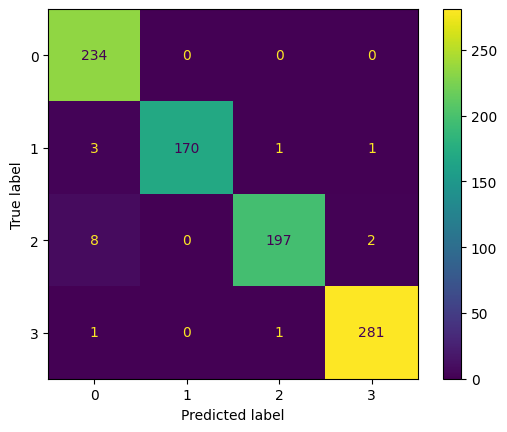


test data confusion matrix


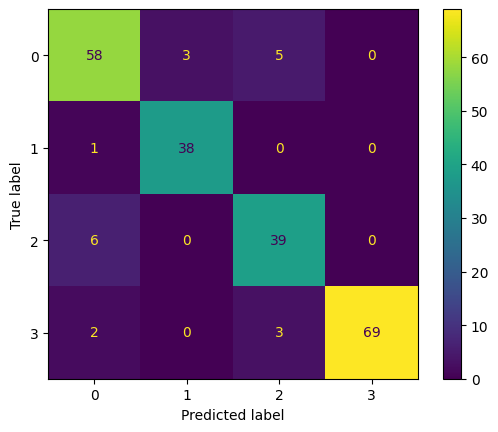


Total Accuracy:  0.8834087133407593
Total Loss:  0.3462441325187683


In [32]:
inputs = np.array(data_pictures)
outputs = np.array(data_labels)

fold_num = 1
folds_accuracy = []
folds_loss = []

# K0Fold implementation
kfold = KFold(n_splits=5, shuffle=True)
for train, test in kfold.split(inputs, outputs):
  model = resnet_model((200, 200, 3), 4)      #model
  model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
  )
  # train the model
  tf.debugging.set_log_device_placement(True)
  with tf.device('/GPU:0'): #using gpu
    history = model.fit(inputs[train], outputs[train], epochs=50)

  print()
  # evaluate the model
  scores = model.evaluate(inputs[test], outputs[test])
  print(f'Scores for Fold {fold_num} : {model.metrics_names[0]} = {scores[0]} and {model.metrics_names[1]} = {scores[1]}')

  print()
  folds_loss.append(scores[0])
  folds_accuracy.append(scores[1])
  fold_num = fold_num + 1
  # evaluate the model
  tf.debugging.set_log_device_placement(True)
  with tf.device('/GPU:0'): #using gpu
    reports(model, inputs[train], outputs[train], inputs[test], outputs[test])

print()
print('Total Accuracy: ', str(np.mean(folds_accuracy)))
print('Total Loss: ', str(np.mean(folds_loss)))